### EMTOOLS -- Validation
**Description:** This notebook is for qualitative and quantitative validation of automatically segmented images in the pipeline. It takes a validation image and a raw segmentation image as input, performs the same steps as the postprocessing step, and then validates the test image against the ground truth.

**Author:** Philip Ruthig, Paul Flechsig Institute, Center of Neuropathology and Brain Research Leipzig

**Contact:** philip.ruthig@medizin.uni-leipzig.de // philip.ruthig@gmail.com

**Publication:**
Please contact me if you want to use this code for any publication.

In [1]:
import numpy as np
import tifffile as tf
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
# import os
import pandas as pd
import math as m
# import skimage
import cv2
import scipy
from skimage.measure import regionprops, regionprops_table
from skimage.morphology import disk
import colorcet as cc
# import IPython
%matplotlib inline

In [2]:
def resolve_undersegmentation(outer_labels,inner_labels):
    '''
    resolves undersegmented cells with 'kissing' cells. This function assumes that inner_labels never touch, but outer_labels do.
    Each corresponding outer area must touch each corresponding inner area.

    outer_labels = outer labels with undersegmented kissing cells that need to be seperated
    inner_labels = inner labels without undersegmented kissing cells

    returns: Two arrays of the same shape, with uniform labels across both images. 
    '''
    import numpy as np
    from skimage.segmentation import watershed
    from skimage.feature import peak_local_max
    outer_labels = outer_labels.astype('bool')
    inner_labels = inner_labels.astype('bool')
    # do distance transformation of combined binary image of outer+inner
    seg_dist = ndi.distance_transform_edt(outer_labels+inner_labels)
    # Generate the markers as local maxima of the distance to the background
    coords = peak_local_max(seg_dist, footprint=np.ones((3, 3)), labels=ndi.label(inner_labels)[0], num_peaks_per_label=1)
    # initializie empty mask 
    mask = np.zeros(seg_dist.shape, dtype=bool)
    # insert maximum points into the empty array
    mask[tuple(coords.T)] = True
    # label each maximum
    markers, n = ndi.label(mask)
    # perform watershed on outer_labels and inner_labels combined
    outer_cells = watershed(-seg_dist, markers, mask=(outer_labels+inner_labels))
    inner_cells = np.copy(outer_cells)
    # sort the cells (which are now labeled with the same label inner and outer) back into inner and outer labels
    inner_cells[inner_labels==0] = 0
    outer_cells[inner_labels==True] = 0
    return outer_cells,inner_cells

def keep_largest_structure(boolean_array):
    '''
    This function checks for structures of the same label and keeps only the biggest one.
    This is needed for cells that are double labeled so we can keep the largest one (which, we assume, is the real one).
    This function should only called for a mask of a single cell each time, as it assumes there is only one label in the input array.
    '''
    labeled_array, num_features = ndi.label(boolean_array) # Label each connected component in the boolean array
    component_sizes = np.bincount(labeled_array.ravel()) # Calculate the size of each labeled component
    largest_component_index = np.argmax(component_sizes[1:]) + 1 # Find the index of the largest component
    largest_component_mask = labeled_array == largest_component_index # Create a boolean mask to keep only the largest component
    # Apply the mask to the boolean array
    boolean_array[largest_component_mask] = True
    boolean_array[~largest_component_mask] = False

    return boolean_array

def calculate_iou(predicted_mask, ground_truth_mask):
    # IoU Score is equivalent to Jaccard
    intersection = predicted_mask & ground_truth_mask # element-wise logical AND
    union = predicted_mask | ground_truth_mask #element-wise logical OR

    # calculate the number of pixels in the intersection and union masks
    n_intersection = intersection.sum()
    n_union = union.sum()

    # calculate the IoU score
    iou = n_intersection / n_union

    return iou

def calculate_dice(predicted_mask, ground_truth_mask):
    # Dice coefficient is equivalent to F1 score.
    intersection = np.sum(predicted_mask[ground_truth_mask == True] == True)
    sum_predicted = np.sum(predicted_mask[predicted_mask == True] == True)
    sum_ground_truth = np.sum(ground_truth_mask[ground_truth_mask == True] == True)

    dice = (2.0 * intersection) / (sum_predicted + sum_ground_truth)
    return dice


# define qualitative colormap
glasbey = cc.cm.glasbey_dark_r
glasbey.set_under(color="black")

In [3]:
prediction_path =  r"4_val/prediction_swm.png" #prediction file
validation_path = r"4_val/validation_swm.png" #ground truth file
save_path = r"5_val_results/"

swm = False #True for swm validation, false for CC

threshold_myelin = 50
threshold_fiber_upper = 40 

if swm == True:
    threshold_fiber_lower = 28
else:
    threshold_fiber_lower = 24

threshold_fiber_lower = 26


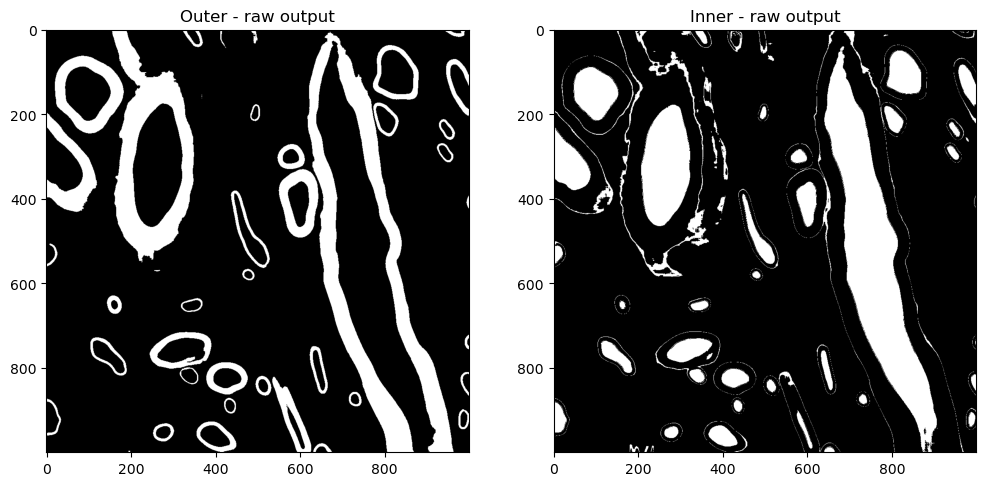

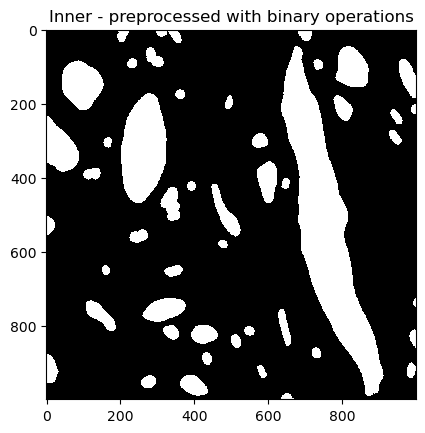

In [4]:
# open data
img = cv2.imread(prediction_path)
img_val = cv2.imread(validation_path)
val_inner = img_val[:,:,2]
val_outer = img_val[:,:,0]

# lose two dimensions, since its a grayscale img 
img = img[:,:,0]

# # plot histogram of pixel intensities in the semantic segmentation
# plt.hist(img.ravel(), bins=256, range=(0, 255),)
# plt.show()

# split different labels
pred_outer = np.zeros_like(img) # myelin
pred_inner = np.zeros_like(img) # fibers

# Treshold the input image at given thresholds (defined in above cell)
pred_outer[img>threshold_myelin] = 1
pred_inner[img<threshold_fiber_upper] = 1
pred_inner[img<threshold_fiber_lower] = 0

# plot raw threshold
fig, axs = plt.subplots(ncols=2,figsize=(12,12))
axs[0].imshow(pred_outer[0:1000,0:1000], cmap='gray')
axs[1].imshow(pred_inner[0:1000,0:1000], cmap='gray')
axs[0].set_title('Outer - raw output')
axs[1].set_title('Inner - raw output')
plt.show()

# binary opening to get rid of small speckles
pred_inner = ndi.binary_opening(pred_inner,structure=disk(5))

# fill holes
# pred_inner = ndi.binary_fill_holes(pred_inner)

# binary opening to get rid of small speckles (again)
pred_inner = ndi.binary_opening(pred_inner,structure=disk(5))

# fill inner to outer label to make sure they touch
pred_inner = ndi.binary_dilation(pred_inner,structure=disk(5))
pred_inner[pred_outer==True]=0

# binary opening to get rid of small speckles
pred_inner = ndi.binary_opening(pred_inner,structure=disk(2))

# fill holes
pred_inner = ndi.binary_fill_holes(pred_inner)

# # binary opening to get rid of small speckles
# pred_inner = ndi.binary_opening(pred_inner,structure=disk(6))

# dilate inner
pred_inner = ndi.binary_dilation(pred_inner,structure=disk(3))

plt.title('Inner - preprocessed with binary operations')
plt.imshow(pred_inner[0:1000,0:1000],interpolation='None',cmap='gray')
plt.show()

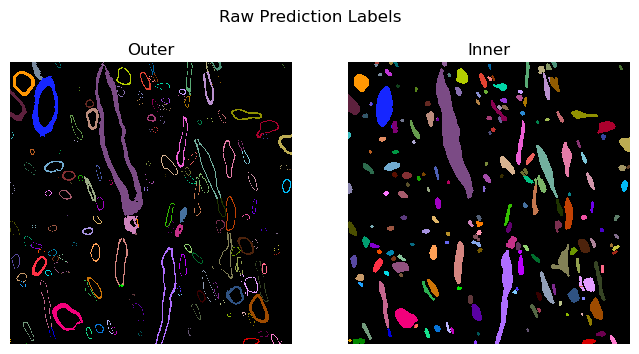

Number of raw predicted cells in the inner channel: 192


In [5]:
pred_outer_labeled, pred_inner_labeled = resolve_undersegmentation(pred_outer.astype('bool'), pred_inner.astype('bool'))

# Plot raw prediction outer and inner side by side
plt.figure(figsize=(8, 4))
plt.suptitle('Raw Prediction Labels', fontsize=12)

# Display raw prediction outer
plt.subplot(1, 2, 1)
plt.title('Outer')
plt.imshow(pred_outer_labeled, cmap=glasbey, interpolation='none', vmin=0.1, vmax=pred_outer_labeled.max())
plt.axis('off')

# Display raw prediction inner
plt.subplot(1, 2, 2)
plt.title('Inner')
plt.imshow(pred_inner_labeled, cmap=glasbey, interpolation='none', vmin=0.1, vmax=pred_outer_labeled.max())
plt.axis('off')
plt.show()
# Print the number of raw predicted cells in the inner channel
n_pred_cells_raw = np.max(pred_inner_labeled)
print("Number of raw predicted cells in the inner channel:", n_pred_cells_raw)


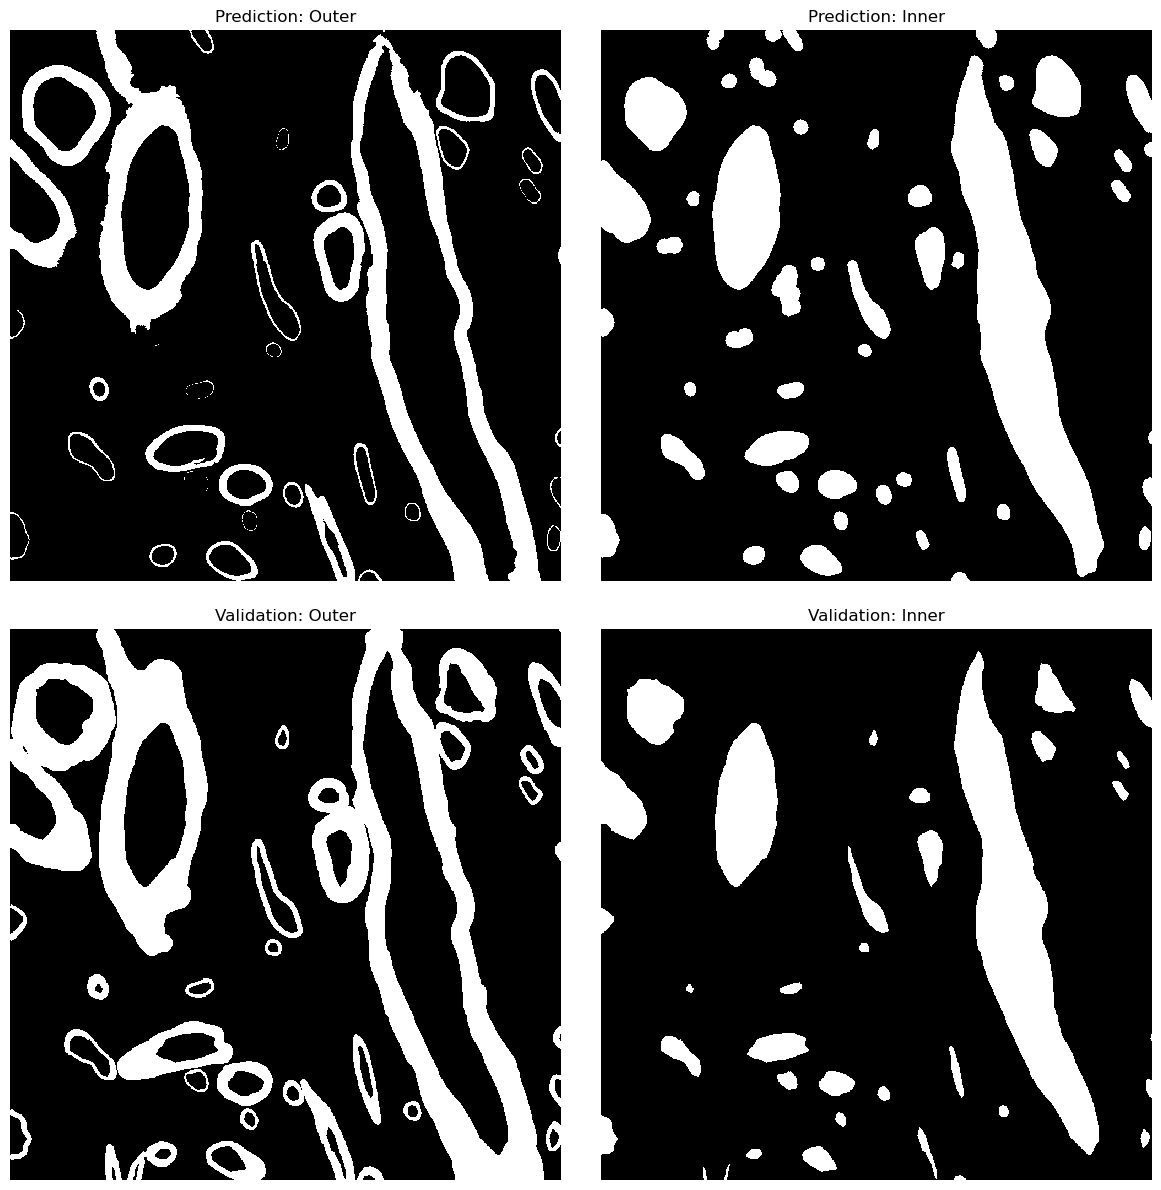

In [6]:
#plot all four channels in 2x2 grid
fig, axs = plt.subplots(ncols=2,nrows=2, figsize=(12,12))
axs[0,0].imshow(pred_outer_labeled[0:1000,0:1000], cmap='gray', interpolation='None',vmin=0.1,vmax=1)
axs[0,1].imshow(pred_inner_labeled[0:1000,0:1000], cmap='gray', interpolation='None',vmin=0.1,vmax=1)
axs[1,0].imshow(val_outer[0:1000,0:1000], cmap='gray', interpolation='None',vmin=0.1,vmax=1)
axs[1,1].imshow(val_inner[0:1000,0:1000], cmap='gray', interpolation='None',vmin=0.1,vmax=1)

# Remove axis for each subplot
axs[0, 0].axis('off')
axs[0, 1].axis('off')
axs[1, 0].axis('off')
axs[1, 1].axis('off')
axs[0,0].set_title('Prediction: Outer')
axs[0,1].set_title('Prediction: Inner')
axs[1,0].set_title('Validation: Outer')
axs[1,1].set_title('Validation: Inner')
plt.tight_layout(h_pad=2)
plt.savefig(save_path + "\predict_val_comparison.png",dpi=500)
plt.show()

In [7]:
# print(len(np.unique(pred_outer_labeled)))
# print(len(np.unique(pred_inner_labeled)))
# print(np.unique(pred_outer_labeled))
# print(np.unique(pred_inner_labeled))

In [8]:
n_labeled_without_outer = 0
n_labeled_without_inner = 0

# iterate through every structure in pred_inner, delete all cells that do not have axon or myelin.
for id in np.unique(pred_inner_labeled):
    # check if id is in pred_outer_labeled
    if id not in pred_outer_labeled:
        # if not, delete in pred_inner_labeled
        pred_inner_labeled[pred_inner_labeled==id] = 0
        print("deleted inner label #" + str(id))
        n_labeled_without_outer += 1

for id in np.unique(pred_outer_labeled):
    if id not in pred_inner_labeled:
        # if not, delete in pred_outer_labeled
        pred_outer_labeled[pred_outer_labeled==id] = 0
        print("deleted outer label #" + str(id))
        n_labeled_without_inner += 1

print (f"Number of cells without axon: {n_labeled_without_inner}")
print (f"Number of cells without myelin: {n_labeled_without_outer}")

deleted inner label #3
deleted inner label #25
deleted inner label #33
deleted inner label #38
deleted inner label #41
deleted inner label #47
deleted inner label #48
deleted inner label #94
deleted inner label #101
deleted inner label #104
deleted inner label #116
deleted inner label #117
deleted inner label #121
deleted inner label #122
deleted inner label #126
deleted inner label #128
deleted inner label #132
deleted inner label #167
deleted inner label #172
deleted inner label #178
deleted inner label #191
Number of cells without axon: 0
Number of cells without myelin: 21


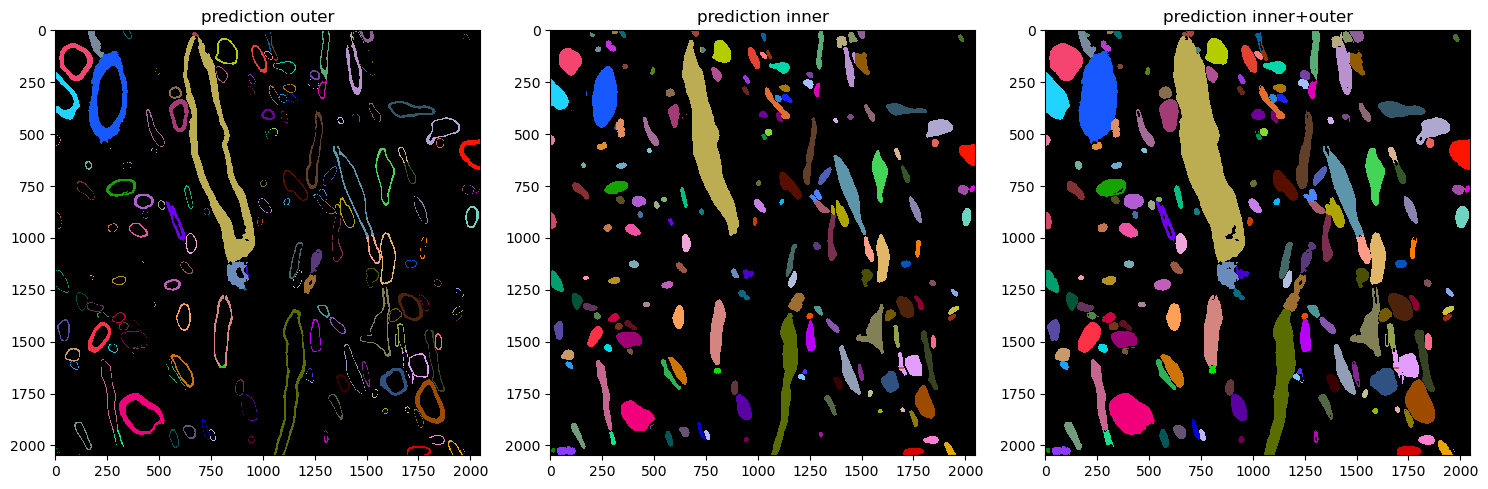

191


In [9]:
pred_outer_labeled,pred_inner_labeled = resolve_undersegmentation(pred_outer_labeled.astype('bool'),pred_inner_labeled.astype('bool'))
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].set_title('prediction outer')
axs[0].imshow(pred_outer_labeled, cmap=glasbey, interpolation='None', vmin=0.1)
axs[1].set_title('prediction inner')
axs[1].imshow(pred_inner_labeled, cmap=glasbey, interpolation='None', vmin=0.1)
axs[2].set_title('prediction inner+outer')
axs[2].imshow(pred_inner_labeled + pred_outer_labeled, cmap=glasbey, interpolation='None', vmin=0.1)
plt.tight_layout()
plt.savefig(save_path + "\\pre_predictions_combined.png", dpi=500)
plt.show()

n_pred_cells_corrected = np.max(pred_inner_labeled)
print(n_pred_cells_corrected)

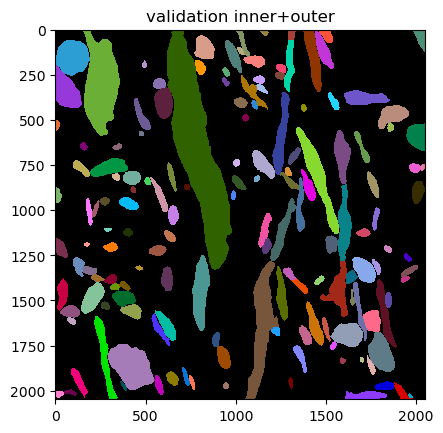

In [10]:
# fill inner to outer label to make sure they touch
# this is needed to ensure good watershed performance later
val_inner = ndi.binary_dilation(val_inner,structure=disk(5))
val_inner[val_outer==True]=0

#re-label so the labels are uniform between both channels.
val_outer_labeled,val_inner_labeled = resolve_undersegmentation(val_outer.astype('bool'),val_inner.astype('bool'))

plt.title('validation inner+outer')
plt.imshow(val_inner_labeled+val_outer_labeled,cmap=glasbey,interpolation='None',vmin=0.1)
plt.show()

In [11]:
# at this point, some of the cells do not have myelin. 
# Since we only look for myelinated cells, these are filtered out here.
idx_list = []
for idx in np.unique(pred_inner_labeled):
    if (pred_outer_labeled==idx).max() == False:
        pred_inner_labeled[pred_inner_labeled==idx] = 0
        idx_list.append(idx)
print('deleted cells because they don\'t have myelin: ' + str(idx_list))

deleted cells because they don't have myelin: [5, 24, 25, 26, 40, 42, 44, 46, 48, 49, 52, 55, 56, 166, 171, 177, 179]


In [12]:
pred_both_labeled = pred_inner_labeled+pred_outer_labeled
val_both_labeled = val_inner_labeled+val_outer_labeled
val_both_labeled[val_both_labeled>0] += 10000 # seperating val and pred labels

#### Cleanup of predicted data without information from validation data

In [13]:
#### Post-Process filtering
# if there are multiple independent labels with the same labelling number,
# keep only the biggest one
for id in np.unique(pred_both_labeled):
    if id == 0:
        continue
    current_id_mask = pred_both_labeled==id 
    mask_labeled, n = ndi.label(current_id_mask)
    if n > 1:
        #delete all but the biggest one from this image and from pred_both_labeled
        current_id_kept = keep_largest_structure(current_id_mask)
        #correct the value of the boolean array to the current id
        current_id_kept = (current_id_kept*id).astype('uint16')
        #re-insert the remaining one to pred_both_labeled
        pred_both_labeled[pred_both_labeled==id] = 0
        pred_both_labeled = pred_both_labeled + current_id_kept        
        print ("Removed " + str(n-1) + " inner duplicates from id #" + str(id))

# if fibers are unreasonably small, remove them from further analysis.
for id in np.unique(pred_both_labeled):
    n_px = (np.count_nonzero(pred_both_labeled[pred_both_labeled==id]))
    if n_px < 5:
        pred_both_labeled[pred_both_labeled==id]=0
        print('deleted because smaller than 5 px: cell #' + str(id))

deleted because smaller than 5 px: cell #0


In [14]:
#seperate inner and outer channels from the combined pictures of predictions
pred_inner_labeled = np.copy(pred_both_labeled)
pred_inner_labeled[pred_inner==False]=0

pred_outer_labeled = np.copy(pred_both_labeled)
pred_outer_labeled[pred_outer==False]=0

# if fibers have a g ratio of >1, delete them from the predictions
table = regionprops_table(label_image=pred_inner_labeled,
                          properties=('minor_axis_length',))
measurements_inner = pd.DataFrame(table)

table = regionprops_table(label_image=pred_outer_labeled,
                          properties=('minor_axis_length',))
measurements_outer = pd.DataFrame(table)

#re-label columns
measurements_outer.columns = ['outer_' + col for col in measurements_outer.columns]
measurements_inner.columns = ['inner_' + col for col in measurements_inner.columns]

#put them in a single dataframe
measurements = pd.concat([measurements_inner,measurements_outer],axis=1)

px_size=4.3*4 # px size in nm

# correct all lengths and areas to the right size
factor_length = px_size / 1000 # 10^3 is from nm to µm
measurements['inner_minor_axis_length'] *= factor_length
measurements['outer_minor_axis_length'] *= factor_length

#add gratio to combined dataframe
measurements['gratio'] = measurements['inner_minor_axis_length']/measurements['outer_minor_axis_length']

# remove all cells with gratio >1 (since that is impossible)
index_gratio_greater_than_1 = list(measurements[measurements['gratio'] > 1].index)
index_gratio_greater_than_1 = [index + 1 for index in index_gratio_greater_than_1]
measurements = measurements[measurements['gratio'] <= 1]

# remove them from the combined image before continuing.
for id in np.unique(index_gratio_greater_than_1):
    pred_both_labeled[pred_both_labeled==id]=0

print(f'Cells with g ratio larger than 1: {index_gratio_greater_than_1}')

Cells with g ratio larger than 1: [1, 3, 8, 9, 10, 20, 30, 43, 45, 51, 53, 72, 99, 109, 112, 120, 142, 143, 173]


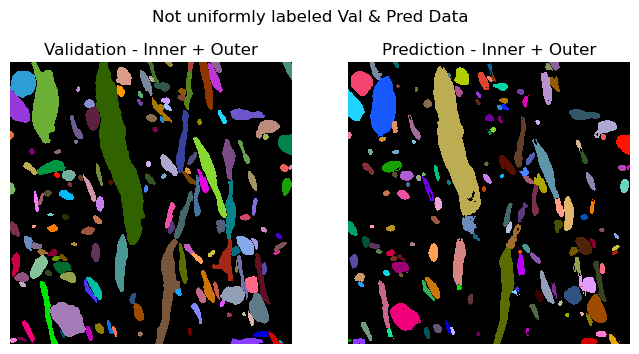

In [15]:
# Plot mislabeled validation and prediction data side by side
plt.figure(figsize=(8, 4))
plt.suptitle('Not uniformly labeled Val & Pred Data', fontsize=12)

# Display mislabeled validation data
plt.subplot(1, 2, 1)
plt.title('Validation - Inner + Outer')
plt.imshow(val_both_labeled, cmap=glasbey, interpolation='none', vmin=10000)
plt.axis('off')

# Display mislabeled prediction data
plt.subplot(1, 2, 2)
plt.title('Prediction - Inner + Outer')
plt.imshow(pred_both_labeled, cmap=glasbey, interpolation='none', vmin=0.1)
plt.axis('off')

# Show the plots side by side
plt.show()


In [16]:
#seperate inner and outer channels back from the combined pictures
pred_inner_labeled = np.copy(pred_both_labeled)
pred_inner_labeled[pred_inner==False]=0

pred_outer_labeled = np.copy(pred_both_labeled)
pred_outer_labeled[pred_outer==False]=0

val_inner_labeled = np.copy(val_both_labeled)
val_inner_labeled[val_inner==False] = 0

val_outer_labeled = np.copy(val_both_labeled)
val_outer_labeled[val_outer==False] = 0

### calculate IoU scores (before removing false positives/negatives)
iou_inner_before = calculate_iou(pred_inner_labeled.astype('bool'),val_inner_labeled.astype('bool'))
iou_outer_before = calculate_iou(pred_outer_labeled.astype('bool'),val_outer_labeled.astype('bool'))
### calculate Dice Coefficients / F1 score
dice_inner_before = calculate_dice(pred_inner_labeled.astype('bool'),val_inner_labeled.astype('bool'))
dice_outer_before = calculate_dice(pred_outer_labeled.astype('bool'),val_outer_labeled.astype('bool'))

print(iou_inner_before,iou_outer_before,dice_inner_before,dice_outer_before)

0.7441988372924424 0.5549547630385203 0.8533417422152149 0.7137889490162264


In [17]:
# take copies of both val and pred data to evaluate in the end, without sorting out false positives and negatives from the data.
pred_copy_before = np.copy(pred_both_labeled)
val_copy_before = np.copy(val_both_labeled)

In [18]:
n_false_positive = 0
n_false_negative = 0
overlap_thresh = 0.4

overlap_perc_list_1 = []
overlap_perc_list_2 = []

# iterate through validation cells one by one.
for id in np.unique(val_both_labeled):
    if id==0:
        continue
    current_label = val_both_labeled==id
    current_area = np.count_nonzero(current_label.astype('bool'))
    # check if the cell has a sufficiently overlapping prediction cell
    # get bounding box of current cell
    current_measurements = regionprops_table(current_label.astype('uint8'),properties=('area','bbox'))
    # get corresponding slice of predicted cell
    # and find the largest structure in it
    dict_current = np.array((np.unique(pred_both_labeled[current_measurements['bbox-0'][0]
                                                   :current_measurements['bbox-2'][0]
                                                   ,current_measurements['bbox-1'][0]
                                                   :current_measurements['bbox-3'][0]
                                                   ],return_counts=True)))
    try:
        current_maximum = dict_current[1,1:].max() # find largest structure
    except ValueError:
        print(f'overlap thresh not met (cell not found). increase false negative by 1 and and deleting cell# {id}')
        continue
    y,x = np.argwhere(dict_current==current_maximum)[0] #get its y and x coordinates in the table of labeled structures
    current_pred_id = dict_current[y-1,x] # get the corresponding pred label number
    
    # check the overlap between the structure in pred and val
    overlap_abs = np.logical_and(pred_both_labeled==current_pred_id,val_both_labeled==id)
    overlap_perc = np.count_nonzero(overlap_abs)/np.count_nonzero(current_label)
    overlap_perc_list_1.append(overlap_perc)

    if overlap_perc > overlap_thresh:# if the overlap threshold is met:
        print('overlap thresh met. labelling with the same color as in val.')
        pred_both_labeled[pred_both_labeled==current_pred_id] = id
    else: # if the overlap is not met: 
        val_both_labeled[val_both_labeled==id] = 0
        n_false_negative += 1
        print(f'overlap thresh not met. increase false negative by 1 and deleting cell# {id}')
        if current_pred_id == None:
            print('None')
            break
    

overlap thresh not met (cell not found). increase false negative by 1 and and deleting cell# 10001
overlap thresh not met (cell not found). increase false negative by 1 and and deleting cell# 10002


overlap thresh met. labelling with the same color as in val.
overlap thresh not met (cell not found). increase false negative by 1 and and deleting cell# 10004
overlap thresh met. labelling with the same color as in val.
overlap thresh not met. increase false negative by 1 and deleting cell# 10006
overlap thresh met. labelling with the same color as in val.
overlap thresh met. labelling with the same color as in val.
overlap thresh met. labelling with the same color as in val.
overlap thresh met. labelling with the same color as in val.
overlap thresh met. labelling with the same color as in val.
overlap thresh met. labelling with the same color as in val.
overlap thresh met. labelling with the same color as in val.
overlap thresh met. labelling with the same color as in val.
overlap thresh met. labelling with the same color as in val.
overlap thresh met. labelling with the same color as in val.
overlap thresh not met. increase false negative by 1 and deleting cell# 10017
overlap thres

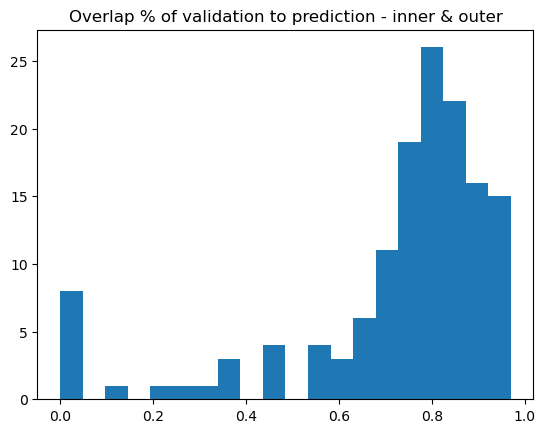

In [19]:
plt.title("Overlap % of validation to prediction - inner & outer")
plt.hist(overlap_perc_list_1,bins=20) #sanity check
plt.show()

In [20]:
# iterate through prediction cells one by one.
for id in np.unique(pred_both_labeled):
    if id==0:
        continue
    current_label = pred_both_labeled==id
    current_area = np.count_nonzero(current_label.astype('bool'))
    # plt.imshow(current_label)
    # check if the cell has a sufficiently overlapping prediction cell
    # get bounding box of current cell
    current_measurements = regionprops_table(current_label.astype('uint8'),properties=('area','bbox'))
    # get corresponding slice of predicted cell
    # and find the largest structure in it
    dict_current = np.array((np.unique(val_both_labeled[current_measurements['bbox-0'][0]
                                                   :current_measurements['bbox-2'][0]
                                                   ,current_measurements['bbox-1'][0]
                                                   :current_measurements['bbox-3'][0]
                                                   ],return_counts=True)))
    try:
        current_maximum = dict_current[1,1:].max() # find largest structure
    except ValueError:
        print(f'overlap thresh not met (cell not found). increase false positive by and and deleting cell# {id}')
        continue
    y,x = np.argwhere(dict_current==current_maximum)[0] #get its y and x coordinates in the table of labeled structures
    current_val_id = dict_current[y-1,x] # get the corresponding val label number
    
    # check the overlap between the structure in pred and val
    overlap_abs = np.logical_and(val_both_labeled==current_val_id,pred_both_labeled==id)
    overlap_perc = np.count_nonzero(overlap_abs)/np.count_nonzero(current_label)
    overlap_perc_list_2.append(overlap_perc)
    if overlap_perc > overlap_thresh:# if the overlap threshold is met:
        print('overlap thresh met. labelling with the same color as in val.')
        pred_both_labeled[pred_both_labeled==id] = current_val_id
    
    else: # if the overlap is not met: 
        pred_both_labeled[pred_both_labeled==id] = 0
        n_false_positive += 1
        print(f'overlap thresh not met. increase false positive by 1 and deleting cell# {id}')
        if current_val_id == None:
            print('None')
            break

overlap thresh not met (cell not found). increase false positive by and and deleting cell# 2
overlap thresh not met. increase false positive by 1 and deleting cell# 6
overlap thresh met. labelling with the same color as in val.
overlap thresh not met. increase false positive by 1 and deleting cell# 11
overlap thresh met. labelling with the same color as in val.
overlap thresh not met. increase false positive by 1 and deleting cell# 14
overlap thresh not met (cell not found). increase false positive by and and deleting cell# 21
overlap thresh not met. increase false positive by 1 and deleting cell# 33
overlap thresh not met (cell not found). increase false positive by and and deleting cell# 34
overlap thresh not met. increase false positive by 1 and deleting cell# 38
overlap thresh not met (cell not found). increase false positive by and and deleting cell# 54
overlap thresh not met. increase false positive by 1 and deleting cell# 58
overlap thresh not met. increase false positive by 1 a

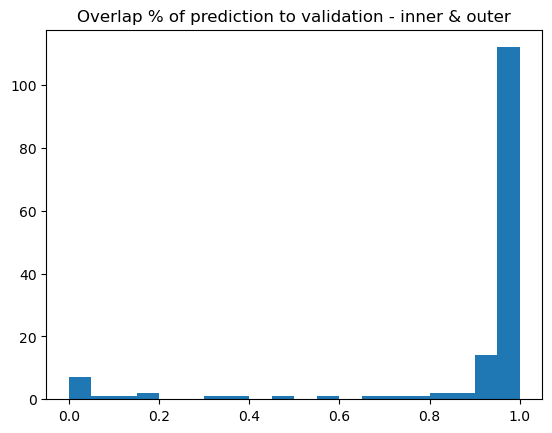

In [21]:
plt.title("Overlap % of prediction to validation - inner & outer")
plt.hist(overlap_perc_list_2,bins=20) #sanity check
plt.show()

In [22]:
print(f"Number of cells in prediction dataset: {len(np.unique(pred_both_labeled))}")
print(f"Number of cells in validation dataset: {len(np.unique(val_both_labeled))}")

Number of cells in prediction dataset: 132
Number of cells in validation dataset: 139


In [23]:
# here, we hard filter every cell that does not have a correspondingly labeled val or pred cell.
# iterate through np.unique(pred_both_labeled), delete all cells that do not have corresponding val cell.
# then do the same other way around.
for id in np.unique(pred_both_labeled):
    # check if id is in val_outer_labeled
    if id not in val_both_labeled:
        # if not, delete in pred_outer_labeled
        pred_both_labeled[pred_both_labeled==id] = 0
        print("deleted prediction label #" + str(id))
        n_false_positive += 1
        print(n_false_positive)

for id in np.unique(val_both_labeled):
    if id not in pred_both_labeled:
        # if not, delete in pred_both_labeled
        val_both_labeled[val_both_labeled==id] = 0
        print("deleted validation label #" + str(id))
        n_false_negative += 1
        print(n_false_negative)


# revert labels back to low values
pred_both_labeled -= 10000
val_both_labeled -= 10000
pred_both_labeled[pred_both_labeled<0]=0
val_both_labeled[val_both_labeled<0]=0

deleted prediction label #2
14
deleted prediction label #21
15
deleted prediction label #34
16
deleted prediction label #54
17
deleted prediction label #103
18
deleted prediction label #155
19
deleted prediction label #189
20
deleted validation label #10001
16
deleted validation label #10002
17
deleted validation label #10004
18
deleted validation label #10029
19
deleted validation label #10042
20
deleted validation label #10068
21
deleted validation label #10073
22
deleted validation label #10074
23
deleted validation label #10077
24
deleted validation label #10078
25
deleted validation label #10088
26
deleted validation label #10104
27
deleted validation label #10114
28
deleted validation label #10149
29


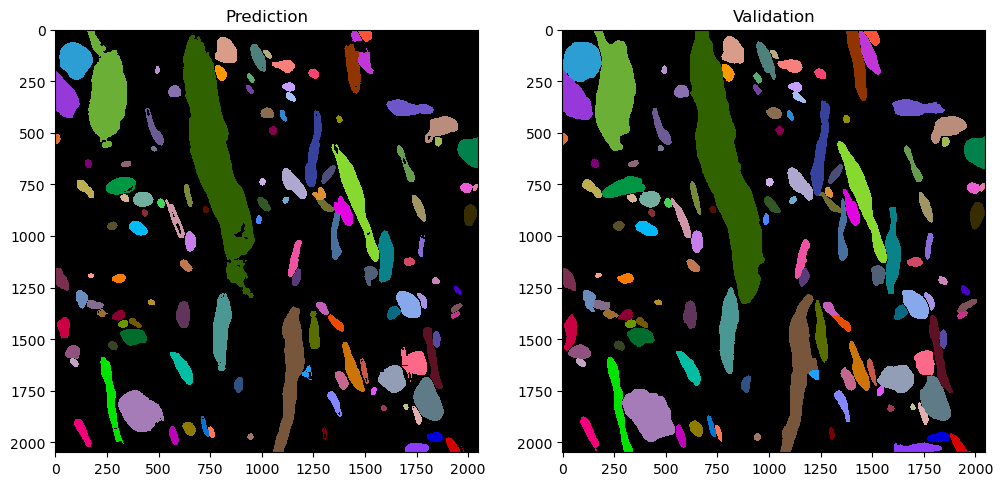

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(pred_both_labeled, cmap=glasbey, interpolation='None', vmin=0.1)
axes[0].set_title('Prediction')
axes[1].imshow(val_both_labeled, cmap=glasbey, interpolation='None', vmin=0.1)
axes[1].set_title('Validation')
plt.show()


In [25]:
print(f"Number of cells in prediction dataset: {len(np.unique(pred_both_labeled))}")
print(f"Number of cells in validation dataset: {len(np.unique(val_both_labeled))}")

Number of cells in prediction dataset: 125
Number of cells in validation dataset: 125


In [26]:
#seperate inner and outer channels back from the combined pictures
pred_inner_labeled = np.copy(pred_both_labeled)
pred_inner_labeled[pred_inner==False]=0

pred_outer_labeled = np.copy(pred_both_labeled)
pred_outer_labeled[pred_outer==False]=0

val_inner_labeled = np.copy(val_both_labeled)
val_inner_labeled[val_inner==False] = 0

val_outer_labeled = np.copy(val_both_labeled)
val_outer_labeled[val_outer==False] = 0

In [27]:
# print(len(np.unique(pred_outer_labeled)))
# print(len(np.unique(pred_inner_labeled)))
# print(len(np.unique(val_outer_labeled)))
# print(len(np.unique(val_inner_labeled)))

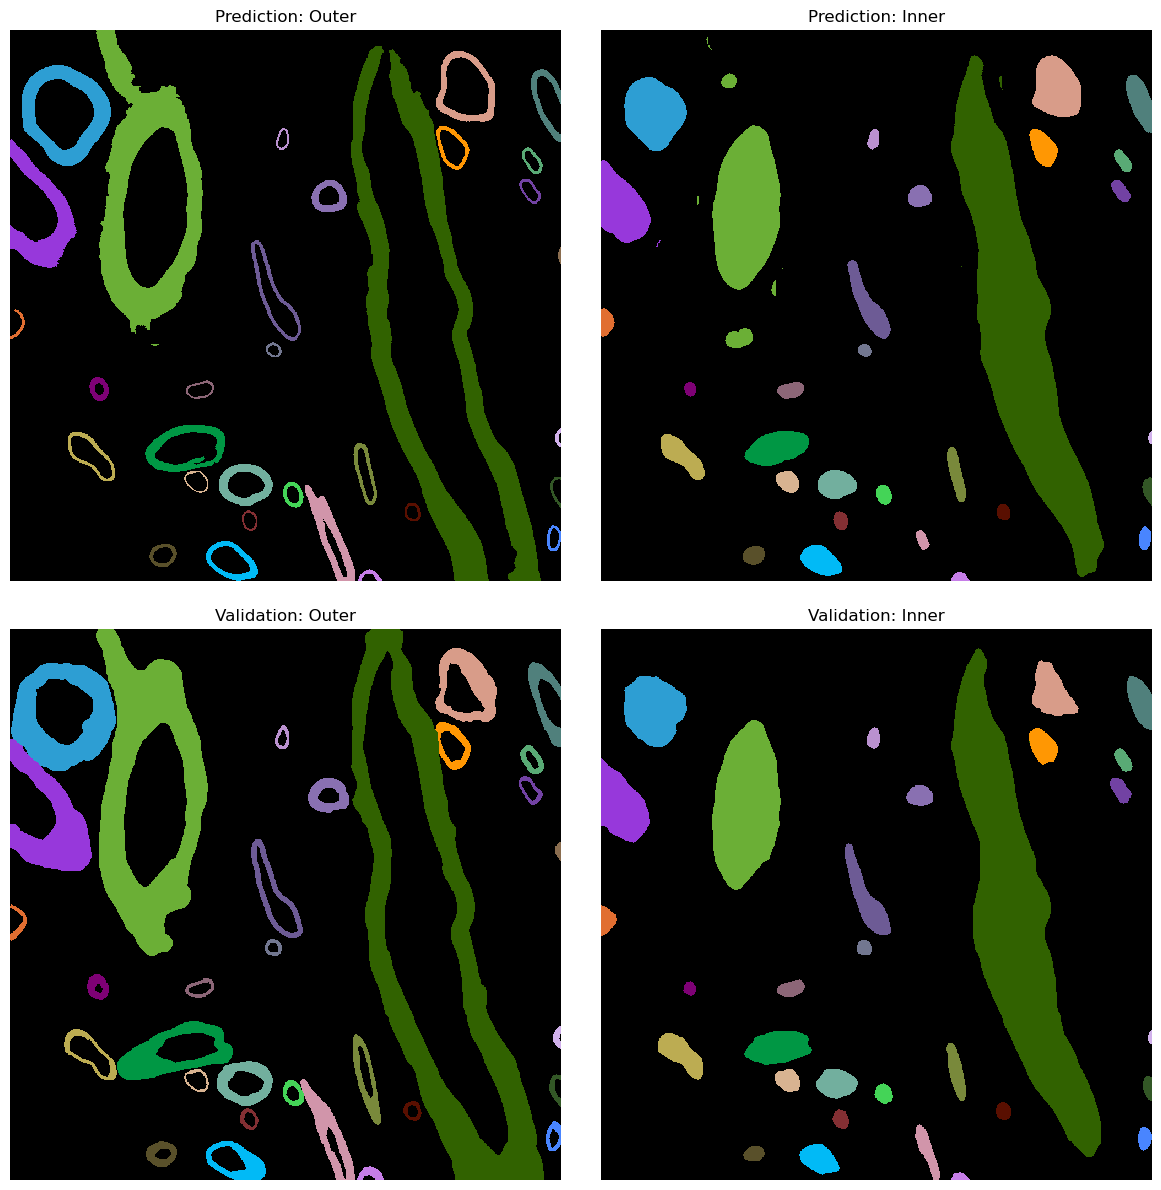

In [28]:
#plot all four channels in 2x2 grid
fig, axs = plt.subplots(ncols=2,nrows=2, figsize=(12,12))
axs[0,0].imshow(pred_outer_labeled[0:1000,0:1000], cmap=glasbey, interpolation='None',vmin=0.1,vmax=pred_outer_labeled.max())
axs[0,1].imshow(pred_inner_labeled[0:1000,0:1000], cmap=glasbey, interpolation='None',vmin=0.1,vmax=pred_outer_labeled.max())
axs[1,0].imshow(val_outer_labeled[0:1000,0:1000], cmap=glasbey, interpolation='None',vmin=0.1,vmax=pred_outer_labeled.max())
axs[1,1].imshow(val_inner_labeled[0:1000,0:1000], cmap=glasbey, interpolation='None',vmin=0.1,vmax=pred_outer_labeled.max())
# Remove axis for each subplot
axs[0, 0].axis('off')
axs[0, 1].axis('off')
axs[1, 0].axis('off')
axs[1, 1].axis('off')
axs[0,0].set_title('Prediction: Outer')
axs[0,1].set_title('Prediction: Inner')
axs[1,0].set_title('Validation: Outer')
axs[1,1].set_title('Validation: Inner')
plt.tight_layout(h_pad=2)
plt.savefig(save_path + "\predict_val_comparison.png",dpi=500)
plt.show()

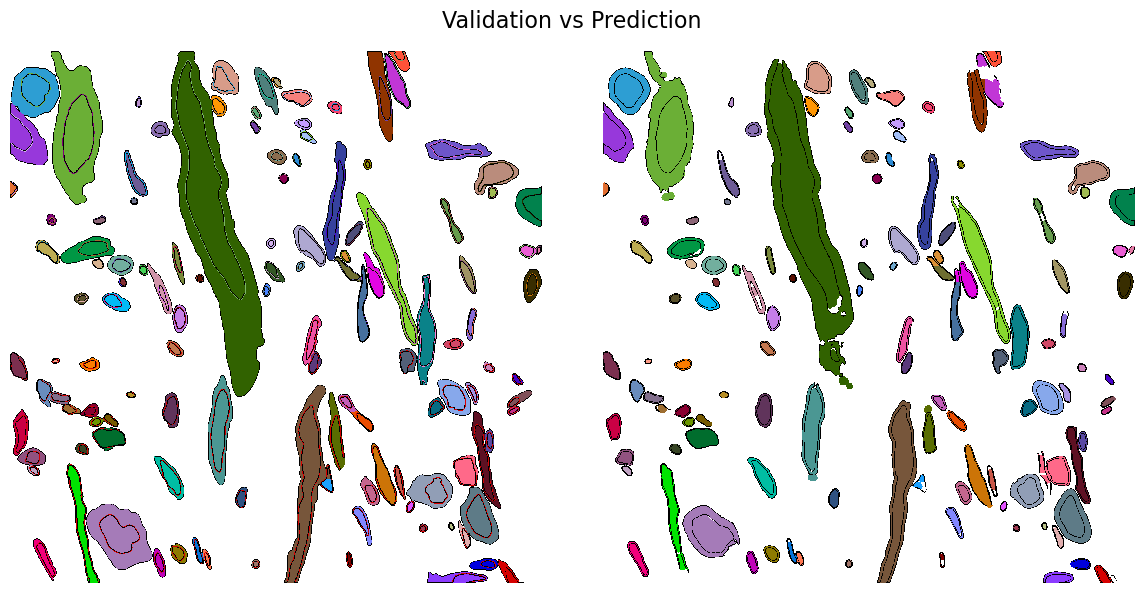

In [29]:
# Function to create outline
def create_outline(image):
    eroded = ndi.binary_erosion(image, structure=disk(3))
    return np.logical_xor(image.astype('bool'), eroded)

# Plot overlay of inner + outer for validation
val_outer_eroded = create_outline(val_outer_labeled)
val_overlay = np.ma.array(val_inner_labeled + val_outer_labeled, mask=(val_inner_labeled + val_outer_labeled) == 0)
val_outline = np.ma.array(val_outer_eroded, mask=(val_outer_eroded) == 0)

plt.figure(figsize=(12, 6))
# Display overlay
plt.subplot(1, 2, 1)
plt.imshow(val_overlay, cmap=glasbey, interpolation='none', vmin=0.1, vmax=pred_outer_labeled.max())
plt.imshow(val_outline, interpolation='none', cmap='gray')
plt.axis('off')

# Plot overlay of inner + outer for prediction
pred_outer_eroded = create_outline(pred_outer_labeled)
pred_overlay = np.ma.array(pred_inner_labeled + pred_outer_labeled, mask=(pred_inner_labeled + pred_outer_labeled) == 0)
pred_outline = np.ma.array(pred_outer_eroded, mask=(pred_outer_eroded) == 0)

plt.subplot(1, 2, 2)
plt.imshow(pred_overlay, cmap=glasbey, interpolation='none', vmin=0.1, vmax=pred_outer_labeled.max())
plt.imshow(pred_outline, interpolation='none', cmap='gray')
plt.axis('off')
plt.suptitle('Validation vs Prediction', fontsize=16)

# Save figures
plt.savefig(save_path + "overlay_and_outlined_cells.png", dpi=500)
plt.tight_layout()
plt.show()


In [30]:
# plt.axis("off")
# plt.imshow(pred_both_labeled,cmap=glasbey,interpolation='None',vmin=0.1,vmax=np.max(pred_both_labeled))
# # plt.imshow(np.ma.array(bool_array_val_labeled, mask=bool_array_val_labeled==0), interpolation='none', cmap='tab20')
# plt.show()

# plt.axis("off")
# plt.imshow(val_both_labeled,cmap=glasbey,interpolation='None',vmin=0.1,vmax=np.max(pred_both_labeled))
# # plt.imshow(np.ma.array(bool_array_val_labeled, mask=bool_array_val_labeled==0), interpolation='none', cmap='tab20')
# plt.show()

In [31]:
# iterate through np.unique(pred_inner_labeled), delete all cells that do not have axon or myelin.
for id in np.unique(pred_inner_labeled):
    # check if id is in pred_outer_labeled
    if id not in pred_outer_labeled:
        # if not, delete in pred_inner_labeled
        pred_inner_labeled[pred_inner_labeled==id] = 0
        val_inner_labeled[val_inner_labeled==id] = 0
        print("deleted inner label #" + str(id))
        n_labeled_without_outer += 1

for id in np.unique(pred_outer_labeled):
    if id not in pred_inner_labeled:
        # if not, delete in pred_outer_labeled
        pred_outer_labeled[pred_outer_labeled==id] = 0
        val_outer_labeled[val_outer_labeled==id] = 0
        print("deleted outer label #" + str(id))
        n_labeled_without_inner += 1

In [32]:
# if there are multiple independent labels with the same labelling number, keep only the biggest one - Inner
for id in np.unique(pred_inner_labeled):
    if id == 0:
        continue
    current_id_mask = pred_inner_labeled==id 
    mask_labeled, n = ndi.label(current_id_mask)
    if n > 1:
        #delete all but the biggest one from this image and from pred_inner_labeled
        current_id_kept = keep_largest_structure(current_id_mask)
        #correct the value of the boolean array to the current id
        current_id_kept = (current_id_kept*id).astype('uint16')
        #re-insert the remaining one to pred_inner_labeled
        pred_inner_labeled[pred_inner_labeled==id] = 0
        pred_inner_labeled = pred_inner_labeled + current_id_kept        
        print ("Removed " + str(n-1) + " duplicates from id #" + str(id))


Removed 1 duplicates from id #8
Removed 1 duplicates from id #9
Removed 3 duplicates from id #11
Removed 1 duplicates from id #15
Removed 11 duplicates from id #20
Removed 2 duplicates from id #23
Removed 9 duplicates from id #30
Removed 7 duplicates from id #34
Removed 1 duplicates from id #44
Removed 1 duplicates from id #48
Removed 1 duplicates from id #52
Removed 1 duplicates from id #53
Removed 1 duplicates from id #65
Removed 2 duplicates from id #66
Removed 1 duplicates from id #103
Removed 1 duplicates from id #115
Removed 2 duplicates from id #119
Removed 4 duplicates from id #121
Removed 1 duplicates from id #123
Removed 1 duplicates from id #125
Removed 2 duplicates from id #133
Removed 4 duplicates from id #139
Removed 1 duplicates from id #142
Removed 1 duplicates from id #143


In [33]:
# if there are multiple independent labels with the same labelling number, keep only the biggest one - Outer
for id in np.unique(pred_outer_labeled):
    if id == 0:
        continue
    current_id_mask = pred_outer_labeled==id 
    mask_labeled, n = ndi.label(current_id_mask)
    if n > 1:
        #delete all but the biggest one from this image and from pred_inner_labeled
        current_id_kept = keep_largest_structure(current_id_mask)
        #correct the value of the boolean array to the current id
        current_id_kept = (current_id_kept*id).astype('uint16')
        #re-insert the remaining one to pred_inner_labeled
        pred_outer_labeled[pred_outer_labeled==id] = 0
        pred_outer_labeled = pred_outer_labeled + current_id_kept        
        print ("Removed " + str(n-1) + " duplicates from id #" + str(id))


Removed 4 duplicates from id #8
Removed 1 duplicates from id #20
Removed 1 duplicates from id #30
Removed 3 duplicates from id #51
Removed 1 duplicates from id #105
Removed 2 duplicates from id #119


In [34]:
print(len(np.unique(pred_outer_labeled)))
print(len(np.unique(pred_inner_labeled)))
print(len(np.unique(val_outer_labeled)))
print(len(np.unique(val_inner_labeled)))

125
125
125
125


In [35]:
tf.imwrite(save_path + "/pred_inner_labeled.tif",pred_inner_labeled)
tf.imwrite(save_path + "/pred_outer_labeled.tif",pred_outer_labeled)
tf.imwrite(save_path + "/val_inner_labeled.tif",val_inner_labeled)
tf.imwrite(save_path + "/val_outer_labeled.tif",val_outer_labeled)
# tf.imwrite(save_path + "/bool_array_labeled.tif",bool_array_labeled_dil)

In [36]:
### calculate IoU scores (after)
iou_inner_after = calculate_iou(pred_inner_labeled.astype('bool'),val_inner_labeled.astype('bool'))
iou_outer_after = calculate_iou(pred_outer_labeled.astype('bool'),val_outer_labeled.astype('bool'))
### calculate Dice Coefficients / F1 score
dice_inner_after = calculate_dice(pred_inner_labeled.astype('bool'),val_inner_labeled.astype('bool'))
dice_outer_after = calculate_dice(pred_outer_labeled.astype('bool'),val_outer_labeled.astype('bool'))

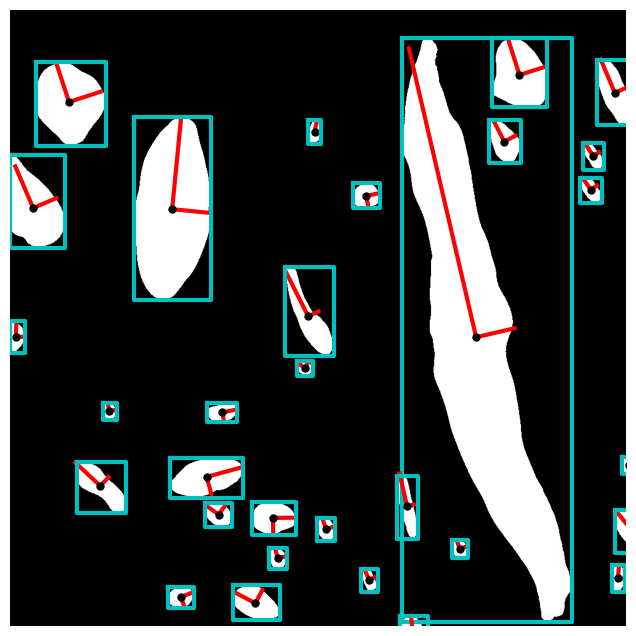

In [37]:
# plot centroids, measurements, major and minor axis on image to sanity check
regions = regionprops(pred_inner_labeled)

fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(pred_inner_labeled.astype('bool'), cmap=plt.cm.gray)

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + m.cos(orientation) * 0.5 * props.minor_axis_length
    y1 = y0 - m.sin(orientation) * 0.5 * props.minor_axis_length
    x2 = x0 - m.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - m.cos(orientation) * 0.5 * props.major_axis_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=3)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=3)
    ax.plot(x0, y0, '.k', markersize=10)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-c', linewidth=3)

ax.set_axis_off()
ax.axis((0, 1000, 1000, 0))
plt.savefig(save_path + "\inner_clocks.png",dpi=500)
plt.show()

In [38]:
### For any validation measures that are not cell-wise but population-wise: 
pred_inner_labeled_before = np.copy(pred_copy_before)
pred_inner_labeled_before[pred_inner==False]=0

pred_outer_labeled_before = np.copy(pred_copy_before)
pred_outer_labeled_before[pred_outer==False]=0

val_inner_labeled_before = np.copy(val_copy_before)
val_inner_labeled_before[val_inner==False] = 0

val_outer_labeled_before = np.copy(val_copy_before)
val_outer_labeled_before[val_outer==False] = 0

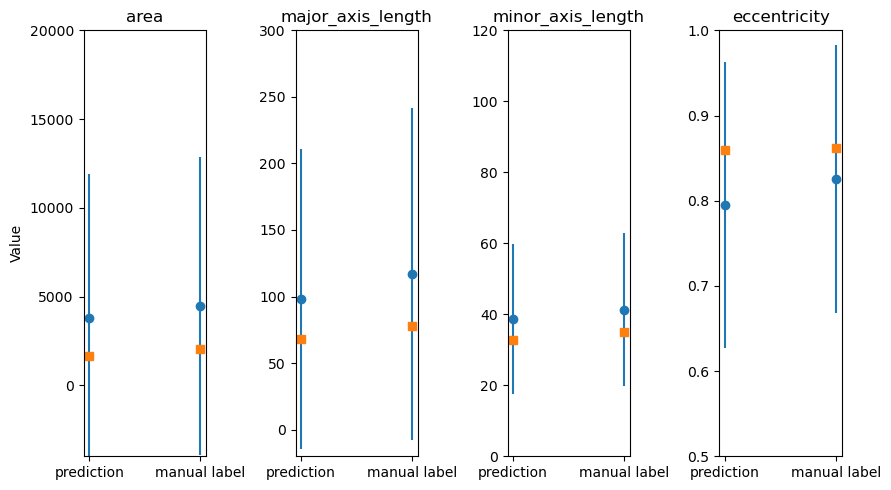

In [39]:
## now that we have the same amount of cells and all cells have the same label in both pictures, we extract measurements for validation
table_inner_pred = regionprops_table(label_image=pred_inner_labeled_before,
                          properties=('label',
                                      'area',
                                      'centroid',
                                      'major_axis_length',
                                      'minor_axis_length',
                                      'eccentricity',
                                      'extent',
                                    #   'equivalent_diameter_area',
                                      'orientation',
                                      'slice',))
measurements_inner_pred = pd.DataFrame(table_inner_pred)

table_inner_val = regionprops_table(label_image=val_inner_labeled_before,
                              properties=('label',
                                          'area',
                                          'centroid',
                                          'major_axis_length',
                                          'minor_axis_length',
                                          'eccentricity',
                                          'extent',
                                        #   'equivalent_diameter_area',
                                          'orientation',
                                          'slice',))
measurements_inner_val = pd.DataFrame(table_inner_val)

# drop uninteresting columns for now
measurements_inner_val=measurements_inner_val.drop(columns=['label','centroid-0','centroid-1','extent','orientation','slice'])
measurements_inner_pred=measurements_inner_pred.drop(columns=['label','centroid-0','centroid-1','extent','orientation','slice'])

# calculate mean and std of all columns for both dataframes
stats_inner_pred = pd.concat([measurements_inner_pred.mean(),measurements_inner_pred.median(), measurements_inner_pred.std()], axis=1)
stats_inner_pred.columns = ['mean','median', 'std']
stats_inner_pred['dataset'] = 'prediction'

stats_inner_val = pd.concat([measurements_inner_val.mean(),measurements_inner_val.median(), measurements_inner_val.std()], axis=1)
stats_inner_val.columns = ['mean','median', 'std']
stats_inner_val['dataset'] = 'manual label'

# combine the two datasets
stats = pd.concat([stats_inner_pred, stats_inner_val])

# plot the data as a box plot
fig, axs = plt.subplots(ncols=measurements_inner_pred.shape[1], figsize=(9, 5),)

for i, col in enumerate(measurements_inner_pred.columns):
    ax = axs[i]
    col_stats = stats.loc[stats.index == col, :]
    xticks = np.arange(len(col_stats))
    ax.errorbar(xticks, col_stats['mean'], yerr=col_stats['std'], fmt='o', label='Mean')
    ax.errorbar(xticks, col_stats['median'], fmt='s', label='Median')
    ax.set_xticks(xticks)
    ax.set_xticklabels(col_stats['dataset'])
    ax.set_title(col)
    if i == 0:
        ax.set_ylabel('Value')
        ax.set_ylim(-4000,20000)
    if i == 1:
        ax.set_ylim(-20,300)
    if i == 2:
        ax.set_ylim(0,120)
    if i == 3:
        ax.set_ylim(0.5,1)
    
plt.tight_layout()
plt.savefig(save_path + "\inner_lineplot.png",dpi=500)
plt.show()

In [40]:
print('predicted stats:')
print(stats_inner_pred)
print('')
print('validation stats:')
print(stats_inner_val)

predicted stats:
                          mean       median          std     dataset
area               3776.554839  1635.000000  8125.895722  prediction
major_axis_length    98.170768    67.732113   112.971211  prediction
minor_axis_length    38.703478    32.849598    21.127981  prediction
eccentricity          0.795368     0.859183     0.167896  prediction

validation stats:
                          mean       median          std       dataset
area               4464.928105  2070.000000  8404.094065  manual label
major_axis_length   117.056133    77.549195   124.456510  manual label
minor_axis_length    41.258579    35.107170    21.514557  manual label
eccentricity          0.825325     0.862232     0.157675  manual label


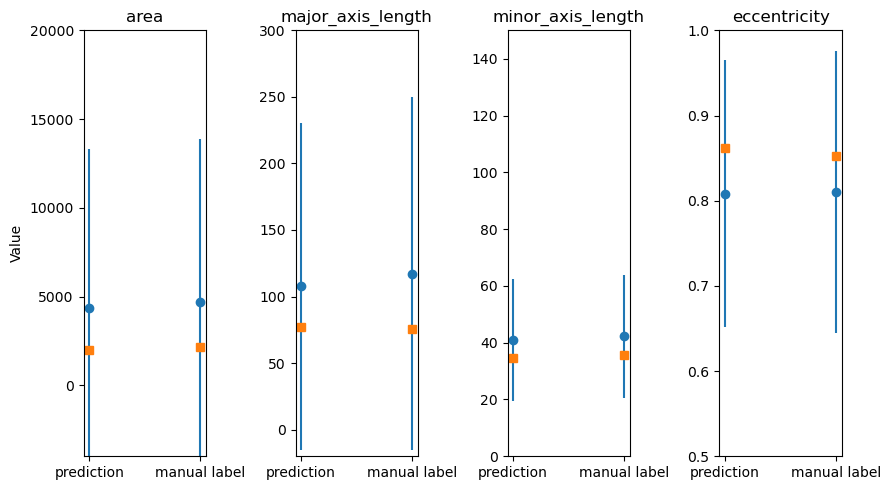

In [41]:
### now do the same, but for the corrected data which has paired cells

## now that we have the same amount of cells and all cells have the same label in both pictures, we extract measurements for validation
table_inner_pred = regionprops_table(label_image=pred_inner_labeled,
                          properties=('label',
                                      'area',
                                      'centroid',
                                      'major_axis_length',
                                      'minor_axis_length',
                                      'eccentricity',
                                      'extent',
                                    #   'equivalent_diameter_area',
                                      'orientation',
                                      'slice',))
measurements_inner_pred = pd.DataFrame(table_inner_pred)

table_inner_val = regionprops_table(label_image=val_inner_labeled,
                              properties=('label',
                                          'area',
                                          'centroid',
                                          'major_axis_length',
                                          'minor_axis_length',
                                          'eccentricity',
                                          'extent',
                                        #   'equivalent_diameter_area',
                                          'orientation',
                                          'slice',))
measurements_inner_val = pd.DataFrame(table_inner_val)

# drop uninteresting columns for now
measurements_inner_val=measurements_inner_val.drop(columns=['label','centroid-0','centroid-1','extent','orientation','slice'])
measurements_inner_pred=measurements_inner_pred.drop(columns=['label','centroid-0','centroid-1','extent','orientation','slice'])

# calculate mean and std of all columns for both dataframes
stats_inner_pred = pd.concat([measurements_inner_pred.mean(),measurements_inner_pred.median(), measurements_inner_pred.std()], axis=1)
stats_inner_pred.columns = ['mean','median', 'std']
stats_inner_pred['dataset'] = 'prediction'

stats_inner_val = pd.concat([measurements_inner_val.mean(),measurements_inner_val.median(), measurements_inner_val.std()], axis=1)
stats_inner_val.columns = ['mean','median', 'std']
stats_inner_val['dataset'] = 'manual label'

# combine the two datasets
stats = pd.concat([stats_inner_pred, stats_inner_val])

# plot the data as a box plot
fig, axs = plt.subplots(ncols=measurements_inner_pred.shape[1], figsize=(9, 5),)

for i, col in enumerate(measurements_inner_pred.columns):
    ax = axs[i]
    col_stats = stats.loc[stats.index == col, :]
    xticks = np.arange(len(col_stats))
    ax.errorbar(xticks, col_stats['mean'], yerr=col_stats['std'], fmt='o', label='Mean')
    ax.errorbar(xticks, col_stats['median'], fmt='s', label='Median')
    ax.set_xticks(xticks)
    ax.set_xticklabels(col_stats['dataset'])
    ax.set_title(col)
    if i == 0:
        ax.set_ylabel('Value')
        ax.set_ylim(-4000,20000)
    if i == 1:
        ax.set_ylim(-20,300)
    if i == 2:
        ax.set_ylim(0,150)
    if i == 3:
        ax.set_ylim(0.5,1)
    
plt.tight_layout()
# plt.savefig(save_path + "\inner_lineplot_after.png",dpi=500)
plt.show()

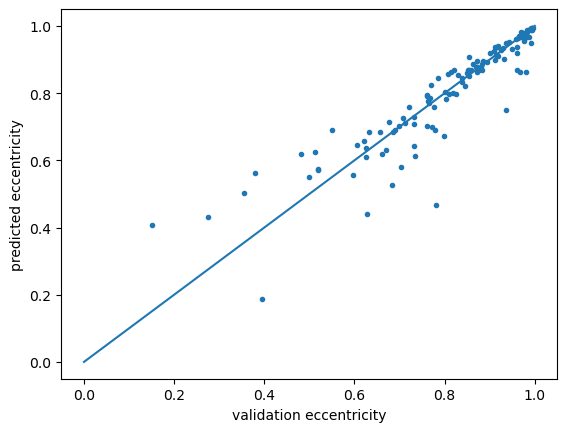

LinregressResult(slope=0.8583864307942836, intercept=0.11258717936227791, rvalue=0.9087294745517508, pvalue=4.020411945311318e-48, stderr=0.035694867912456546, intercept_stderr=0.02951086403025138)


In [42]:
set_val = (measurements_inner_val['eccentricity'])
set_pred = (measurements_inner_pred['eccentricity'])

stats_val_pred = scipy.stats.linregress(set_val,set_pred)

x = np.arange(0,np.max(set_val)*1.1)
y = np.arange(0,np.max(set_val)*1.1)

plt.scatter(set_val,set_pred,marker='.')
plt.plot(x,y)
plt.xlabel('validation eccentricity')
plt.ylabel('predicted eccentricity')
plt.savefig(save_path + "\inner_ecc.png",dpi=500)
plt.show()
print(stats_val_pred)

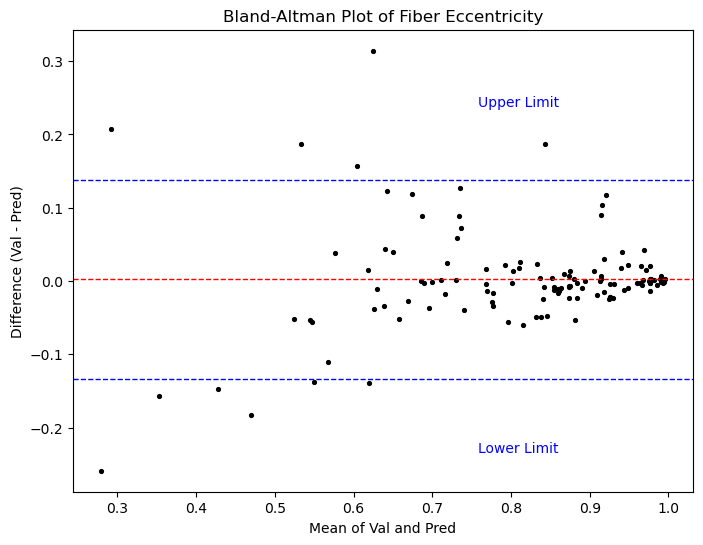

In [43]:
# Assuming set_val and set_pred are numpy arrays or lists
set_val = np.array(set_val)
set_pred = np.array(set_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30, marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of Fiber Eccentricity')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Save plot
plt.savefig(save_path + "\inner_ecc_ba.png",dpi=500)

# Display the plot
plt.show()


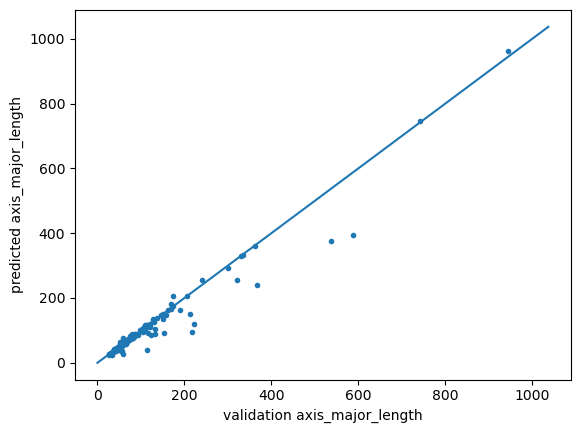

LinregressResult(slope=0.9017742843994927, intercept=2.1334784060412346, rvalue=0.9720771600245415, pvalue=1.1583999608401971e-78, stderr=0.01970874350310328, intercept_stderr=3.4781032339829667)


In [44]:
set_val = (measurements_inner_val['major_axis_length'])
set_pred = (measurements_inner_pred['major_axis_length'])

stats_val_pred = scipy.stats.linregress(set_val,set_pred)

x = np.arange(0,np.max(set_val)*1.1)
y = np.arange(0,np.max(set_val)*1.1)

plt.scatter(set_val,set_pred,marker='.')
plt.plot(x,y)
plt.xlabel('validation axis_major_length')
plt.ylabel('predicted axis_major_length')
#plt.ylim(-20,520)
#plt.xlim(-20,520)
plt.savefig(save_path + "\inner_major.png",dpi=500)
plt.show()
print(stats_val_pred)

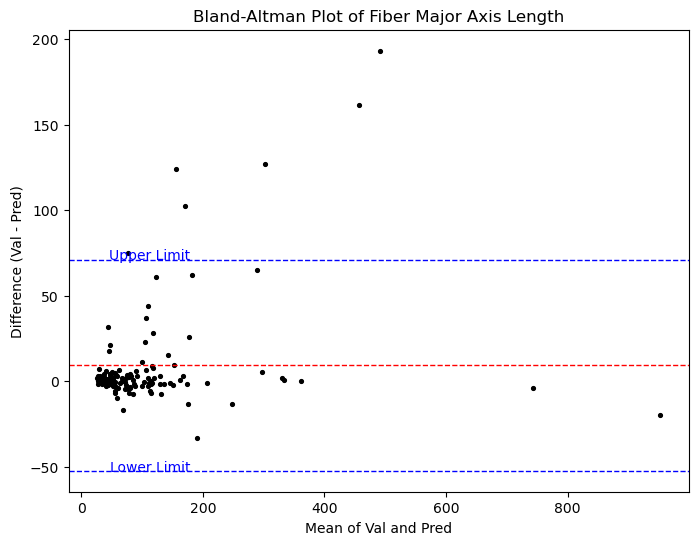

In [45]:
set_val = np.array(set_val)
set_pred = np.array(set_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30,marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of Fiber Major Axis Length')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Display the plot
plt.show()


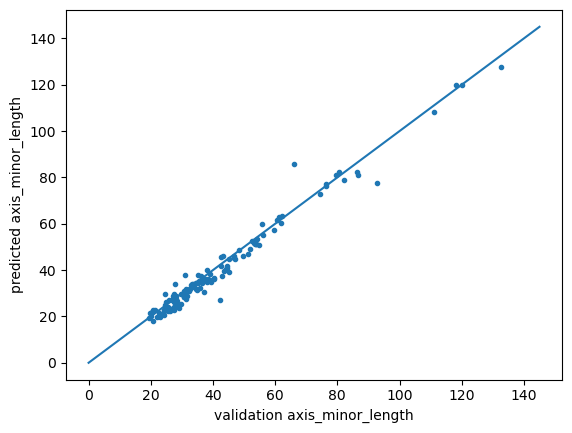

LinregressResult(slope=0.9864746307043849, intercept=-0.7145962309124414, rvalue=0.9863492787644966, pvalue=1.948166307441783e-97, stderr=0.014910111174695796, intercept_stderr=0.7063750765494742)


In [46]:
set_val = (measurements_inner_val['minor_axis_length'])
set_pred = (measurements_inner_pred['minor_axis_length'])

stats_val_pred = scipy.stats.linregress(set_val,set_pred)

x = np.arange(0,np.max(set_val)*1.1)
y = np.arange(0,np.max(set_val)*1.1)

plt.scatter(set_val,set_pred,marker='.')
plt.plot(x,y)
plt.xlabel('validation axis_minor_length')
plt.ylabel('predicted axis_minor_length')
plt.savefig(save_path + "\inner_minor.png",dpi=500)
plt.show()
print(stats_val_pred)

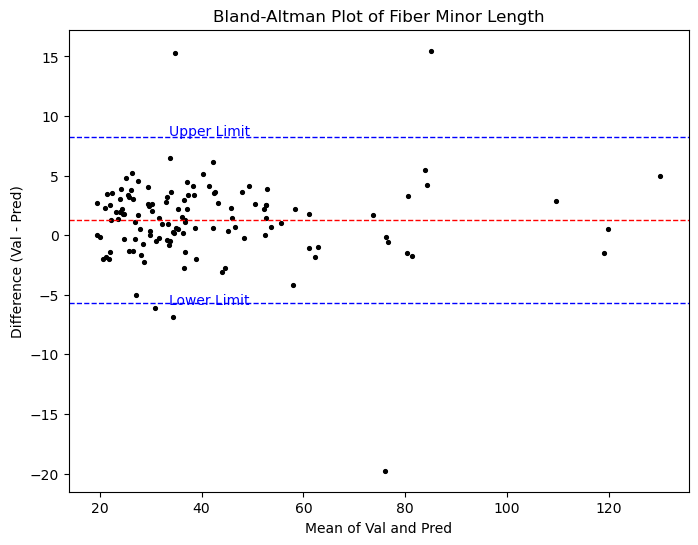

In [47]:
# Assuming set_val and set_pred are numpy arrays or lists
set_val = np.array(set_val)
set_pred = np.array(set_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30, marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of Fiber Minor Length')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Save plot
plt.savefig(save_path + "\inner_minor_ba.png",dpi=500)

# Display the plot
plt.show()


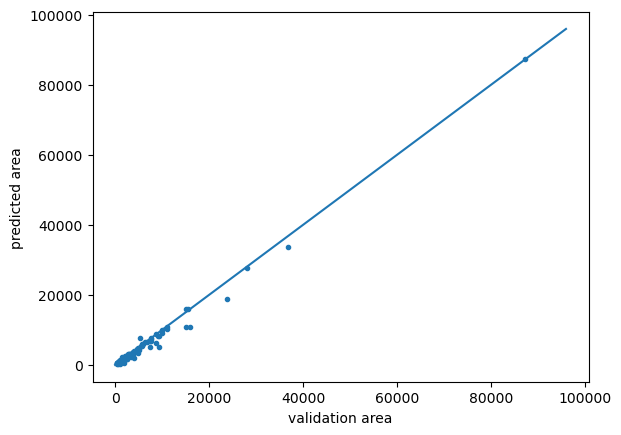

LinregressResult(slope=0.9686023810085336, intercept=-213.79387200055953, rvalue=0.9941329117983971, pvalue=1.0451151134405267e-119, stderr=0.009541343348403869, intercept_stderr=98.20335113569622)


In [48]:
set_val = (measurements_inner_val['area'])
set_pred = (measurements_inner_pred['area'])

stats_val_pred = scipy.stats.linregress(set_val,set_pred)
x = np.arange(0,np.max(set_val)*1.1)
y = np.arange(0,np.max(set_val)*1.1)

plt.scatter(set_val,set_pred,marker='.')
plt.plot(x,y)
plt.xlabel('validation area')
plt.ylabel('predicted area')
plt.savefig(save_path + "\inner_area.png",dpi=500)
plt.show()
print(stats_val_pred)

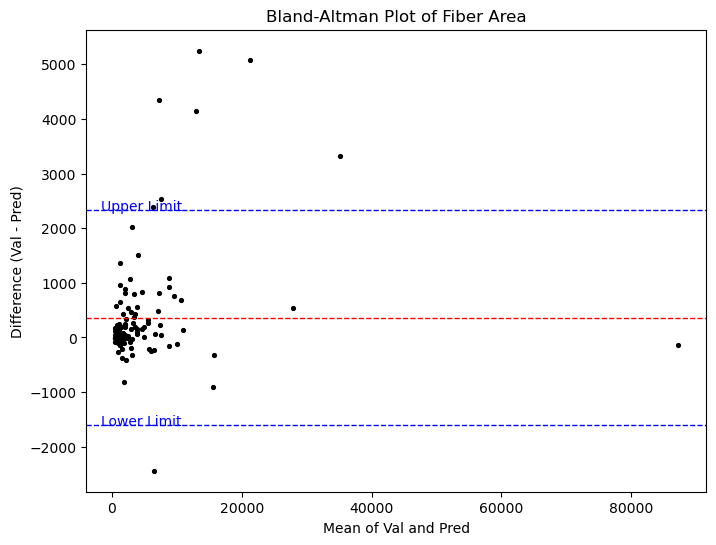

In [49]:
# Assuming set_val and set_pred are numpy arrays or lists
set_val = np.array(set_val)
set_pred = np.array(set_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30, marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of Fiber Area')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Save plot
plt.savefig(save_path + "\inner_area_ba.png",dpi=500)

# Display the plot
plt.show()


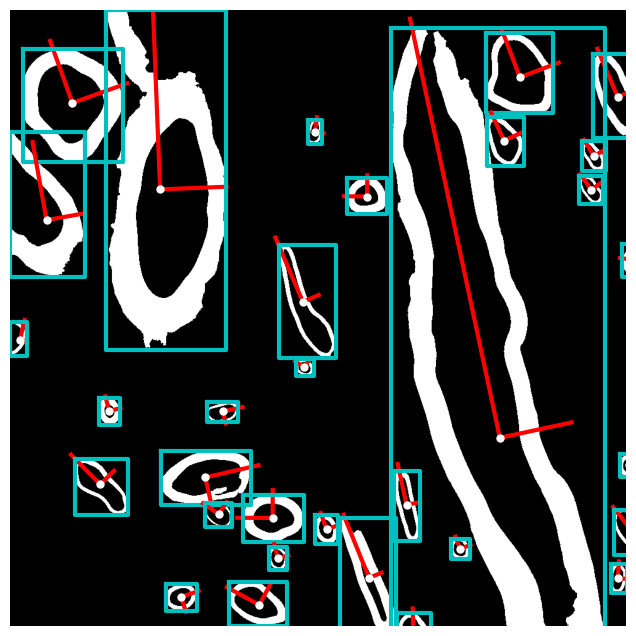

In [50]:
##### now do the same as above for the outer channel
# plot centroids, measurements, major and minor axis on image to sanity check
regions = regionprops(pred_outer_labeled)

fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(pred_outer_labeled.astype('bool'), cmap=plt.cm.gray)

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + m.cos(orientation) * 0.5 * props.minor_axis_length
    y1 = y0 - m.sin(orientation) * 0.5 * props.minor_axis_length
    x2 = x0 - m.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - m.cos(orientation) * 0.5 * props.major_axis_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=3)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=3)
    ax.plot(x0, y0, '.w', markersize=10)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-c', linewidth=3)

ax.set_axis_off()
ax.axis((0, 1000, 1000, 0))
plt.savefig(save_path + "\outer_clocks.png",dpi=500)
plt.show()

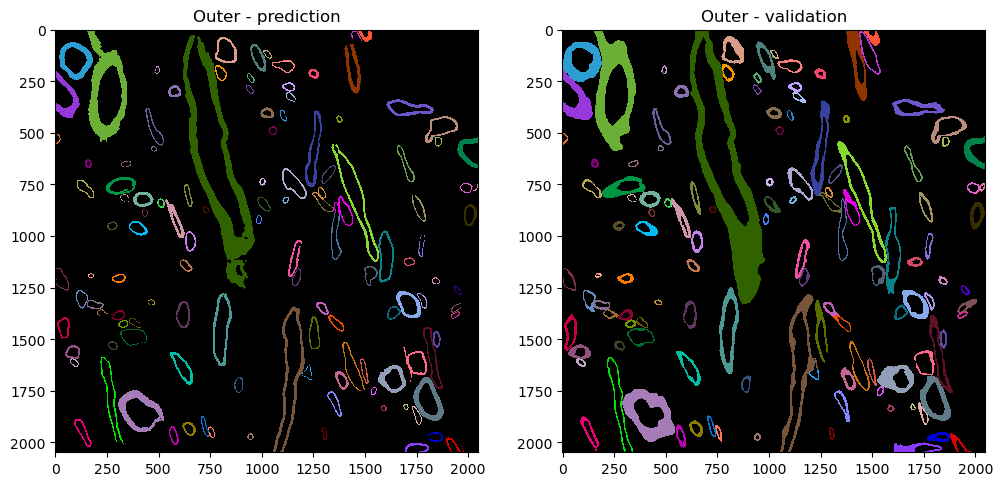

In [51]:
## do the same regression analysis as before
# visually compare outer_labeled and validation data
fig, axs = plt.subplots(ncols=2,figsize=(12,12))
axs[0].imshow(pred_outer_labeled, cmap=glasbey,interpolation='none',vmin=0.1,vmax=pred_outer_labeled.max())
axs[1].imshow(val_outer_labeled, cmap=glasbey,interpolation='none',vmin=0.1,vmax=pred_outer_labeled.max())
axs[0].set_title('Outer - prediction')
axs[1].set_title('Outer - validation')
plt.show()

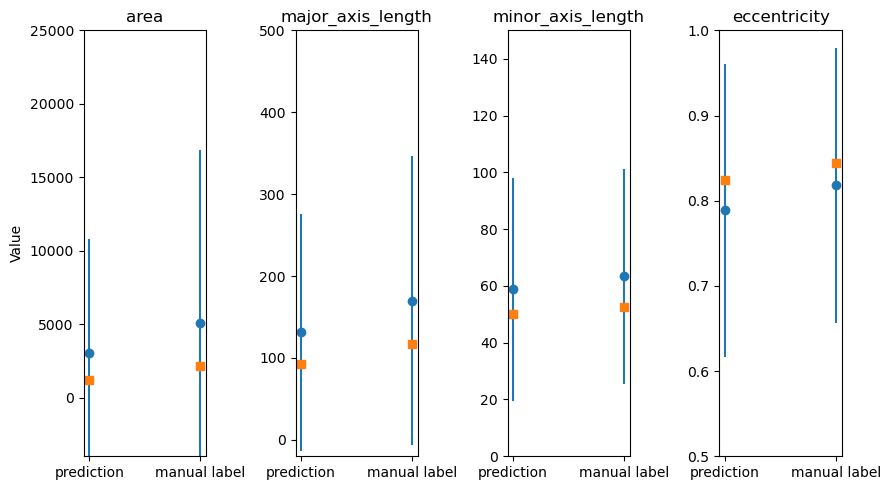

In [52]:
## now that we have the same amount of cells and all cells have the same label in both pictures, we extract measurements for validation
table_outer_pred = regionprops_table(label_image=pred_outer_labeled_before,
                          properties=('label',
                                      'area',
                                      'centroid',
                                      'major_axis_length',
                                      'minor_axis_length',
                                      'eccentricity',
                                      'extent',
                                    #   'equivalent_diameter_area',
                                      'orientation',
                                      'slice'))
measurements_outer_pred = pd.DataFrame(table_outer_pred)
#measurements_outer_pred.drop(66,inplace=True)

table_outer_val = regionprops_table(label_image=val_outer_labeled_before,
                              properties=('label',
                                          'area',
                                          'centroid',
                                        'major_axis_length',
                                        'minor_axis_length',
                                          'eccentricity',
                                          'extent',
                                        #   'equivalent_diameter_area',
                                          'orientation',
                                          'slice'))
measurements_outer_val = pd.DataFrame(table_outer_val)
#measurements_outer_val.drop(66,inplace=True)

# drop uninteresting columns for now
measurements_outer_val=measurements_outer_val.drop(columns=['label','centroid-0','centroid-1','extent','orientation','slice'])
measurements_outer_pred=measurements_outer_pred.drop(columns=['label','centroid-0','centroid-1','extent','orientation','slice'])

# calculate mean and std of all columns for both dataframes
stats_outer_pred = pd.concat([measurements_outer_pred.mean(),measurements_outer_pred.median(), measurements_outer_pred.std()], axis=1)
stats_outer_pred.columns = ['mean','median', 'std']
stats_outer_pred['dataset'] = 'prediction'

stats_outer_val = pd.concat([measurements_outer_val.mean(),measurements_outer_val.median(), measurements_outer_val.std()], axis=1)
stats_outer_val.columns = ['mean','median', 'std']
stats_outer_val['dataset'] = 'manual label'

# combine the two datasets
stats = pd.concat([stats_outer_pred, stats_outer_val])

fig, axs = plt.subplots(ncols=measurements_outer_pred.shape[1], figsize=(9, 5))

for i, col in enumerate(measurements_outer_pred.columns):
    ax = axs[i]
    col_stats = stats.loc[stats.index == col, :]
    xticks = np.arange(len(col_stats))
    
    ax.errorbar(xticks, col_stats['mean'], yerr=col_stats['std'], fmt='o', label='Mean')
    ax.errorbar(xticks, col_stats['median'], fmt='s', label='Median')
    ax.set_xticks(xticks)
    ax.set_xticklabels(col_stats['dataset'])
    ax.set_title(col)
    
    if i == 0:
        ax.set_ylabel('Value')
        ax.set_ylim(-4000,25000)
    if i == 1:
        ax.set_ylim(-20,500)
    if i == 2:
        ax.set_ylim(0,150)
    if i == 3:
        ax.set_ylim(0.5,1)

plt.tight_layout()
plt.savefig(save_path + "\outer_lineplot.png", dpi=500)
plt.show()

In [53]:
print('predicted stats:')
print(stats_outer_pred)
print('')
print('validation stats:')
print(stats_outer_val)

predicted stats:
                          mean       median          std     dataset
area               2999.432258  1225.000000  7826.980560  prediction
major_axis_length   131.135137    92.610072   144.149218  prediction
minor_axis_length    58.759669    50.206855    39.270618  prediction
eccentricity          0.788730     0.824843     0.172106  prediction

validation stats:
                          mean       median           std       dataset
area               5071.718954  2144.000000  11748.589810  manual label
major_axis_length   169.785037   117.609181    176.555540  manual label
minor_axis_length    63.393139    52.684333     37.797388  manual label
eccentricity          0.817968     0.844843      0.160991  manual label


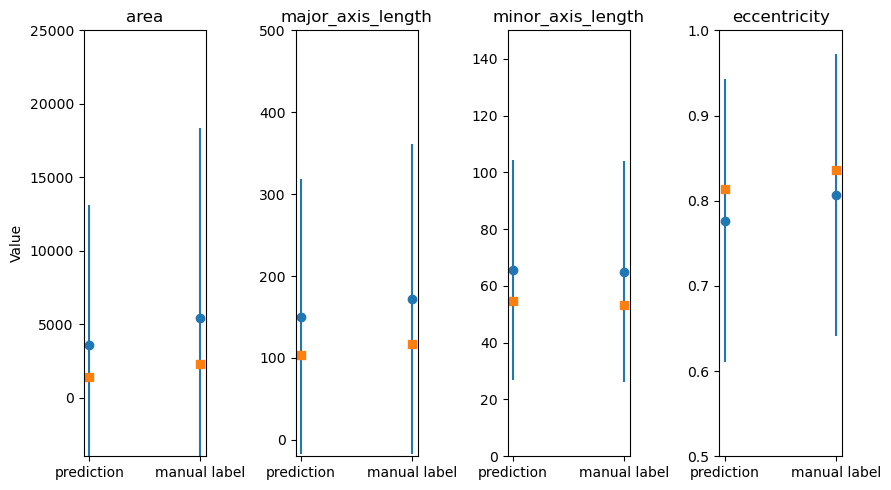

In [54]:
## now that we have the same amount of cells and all cells have the same label in both pictures, we extract measurements for validation
table_outer_pred = regionprops_table(label_image=pred_outer_labeled,
                          properties=('label',
                                      'area',
                                      'centroid',
                                      'major_axis_length',
                                      'minor_axis_length',
                                      'eccentricity',
                                      'extent',
                                    #   'equivalent_diameter_area',
                                      'orientation',
                                      'slice'))
measurements_outer_pred = pd.DataFrame(table_outer_pred)
#measurements_outer_pred.drop(66,inplace=True)

table_outer_val = regionprops_table(label_image=val_outer_labeled,
                              properties=('label',
                                          'area',
                                          'centroid',
                                        'major_axis_length',
                                        'minor_axis_length',
                                          'eccentricity',
                                          'extent',
                                        #   'equivalent_diameter_area',
                                          'orientation',
                                          'slice'))
measurements_outer_val = pd.DataFrame(table_outer_val)
#measurements_outer_val.drop(66,inplace=True)

# drop uninteresting columns for now
measurements_outer_val=measurements_outer_val.drop(columns=['label','centroid-0','centroid-1','extent','orientation','slice'])
measurements_outer_pred=measurements_outer_pred.drop(columns=['label','centroid-0','centroid-1','extent','orientation','slice'])

# calculate mean and std of all columns for both dataframes
stats_outer_pred = pd.concat([measurements_outer_pred.mean(),measurements_outer_pred.median(), measurements_outer_pred.std()], axis=1)
stats_outer_pred.columns = ['mean','median', 'std']
stats_outer_pred['dataset'] = 'prediction'

stats_outer_val = pd.concat([measurements_outer_val.mean(),measurements_outer_val.median(), measurements_outer_val.std()], axis=1)
stats_outer_val.columns = ['mean','median', 'std']
stats_outer_val['dataset'] = 'manual label'

# combine the two datasets
stats = pd.concat([stats_outer_pred, stats_outer_val])

fig, axs = plt.subplots(ncols=measurements_outer_pred.shape[1], figsize=(9, 5))

for i, col in enumerate(measurements_outer_pred.columns):
    ax = axs[i]
    col_stats = stats.loc[stats.index == col, :]
    xticks = np.arange(len(col_stats))
    
    ax.errorbar(xticks, col_stats['mean'], yerr=col_stats['std'], fmt='o', label='Mean')
    ax.errorbar(xticks, col_stats['median'], fmt='s', label='Median')
    ax.set_xticks(xticks)
    ax.set_xticklabels(col_stats['dataset'])
    ax.set_title(col)
    
    if i == 0:
        ax.set_ylabel('Value')
        ax.set_ylim(-4000,25000)
    if i == 1:
        ax.set_ylim(-20,500)
    if i == 2:
        ax.set_ylim(0,150)
    if i == 3:
        ax.set_ylim(0.5,1)
plt.tight_layout()
# plt.savefig(save_path + "\outer_lineplot.png", dpi=500)
plt.show()

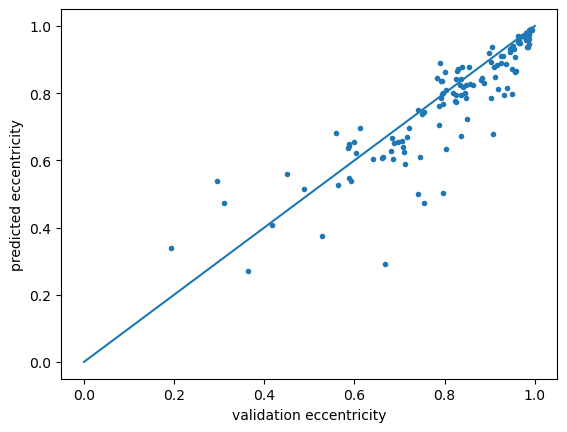

LinregressResult(slope=0.8814760673587371, intercept=0.06539323723229828, rvalue=0.8786872864800138, pvalue=5.450264964121977e-41, stderr=0.04335874209088713, intercept_stderr=0.03571135776479228)


In [55]:
set_val = (measurements_outer_val['eccentricity'])
set_pred = (measurements_outer_pred['eccentricity'])

stats_val_pred = scipy.stats.linregress(set_val,set_pred)
x = np.arange(0,np.max(set_val)*1.1)
y = np.arange(0,np.max(set_val)*1.1)

plt.scatter(set_val,set_pred,marker='.')
plt.plot(x,y)
plt.xlabel('validation eccentricity')
plt.ylabel('predicted eccentricity')
plt.savefig(save_path + "\outer_ecc.png",dpi=500)
plt.show()
print(stats_val_pred)

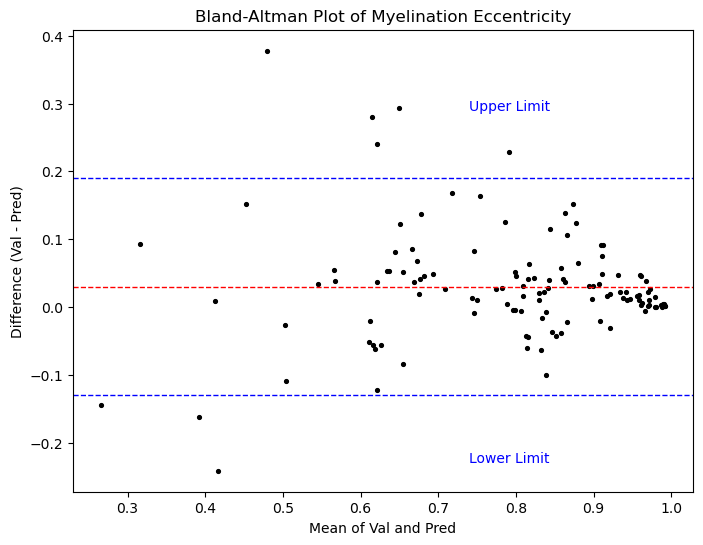

In [56]:
# Assuming set_val and set_pred are numpy arrays or lists
set_val = np.array(set_val)
set_pred = np.array(set_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30, marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of Myelination Eccentricity')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Save plot
plt.savefig(save_path + "\outer_ecc_ba.png",dpi=500)

# Display the plot
plt.show()


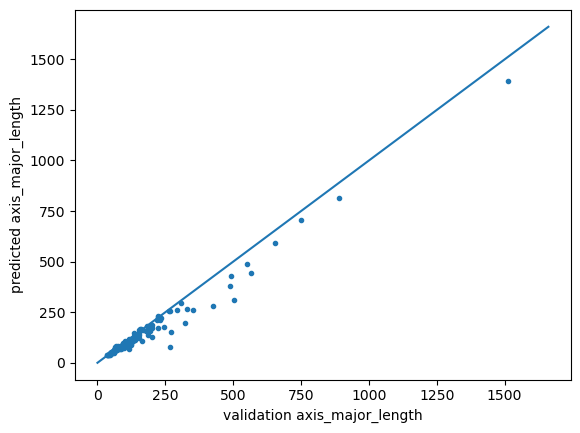

LinregressResult(slope=0.8728820131311277, intercept=0.39063242993765357, rvalue=0.9846559561050217, pvalue=2.320623394202771e-94, stderr=0.014005662243602949, intercept_stderr=3.574680717410647)


In [57]:
set_val = (measurements_outer_val['major_axis_length'])
set_pred = (measurements_outer_pred['major_axis_length'])

stats_val_pred = scipy.stats.linregress(set_val,set_pred)

x = np.arange(0,np.max(set_val)*1.1)
y = np.arange(0,np.max(set_val)*1.1)

plt.scatter(set_val,set_pred,marker='.')
plt.plot(x,y)
plt.xlabel('validation axis_major_length')
plt.ylabel('predicted axis_major_length')
plt.savefig(save_path + "\outer_major.png",dpi=500)
plt.show()
print(stats_val_pred)

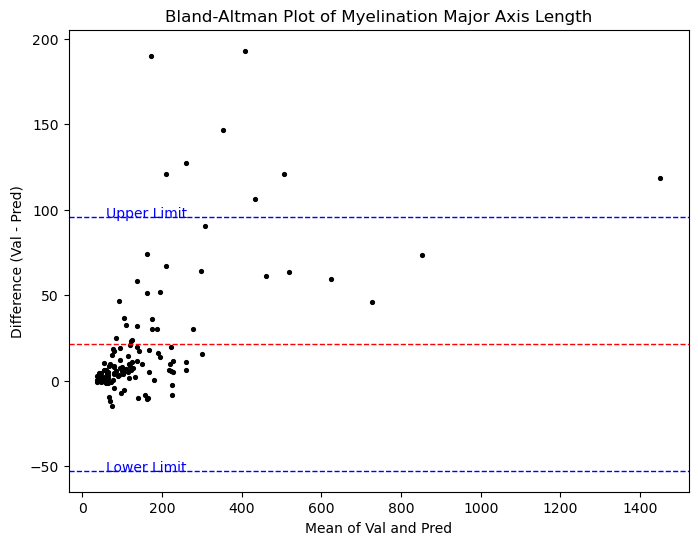

In [58]:
# Assuming set_val and set_pred are numpy arrays or lists
set_val = np.array(set_val)
set_pred = np.array(set_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30, marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of Myelination Major Axis Length')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Save plot
plt.savefig(save_path + "\outer_major_ba.png",dpi=500)

# Display the plot
plt.show()


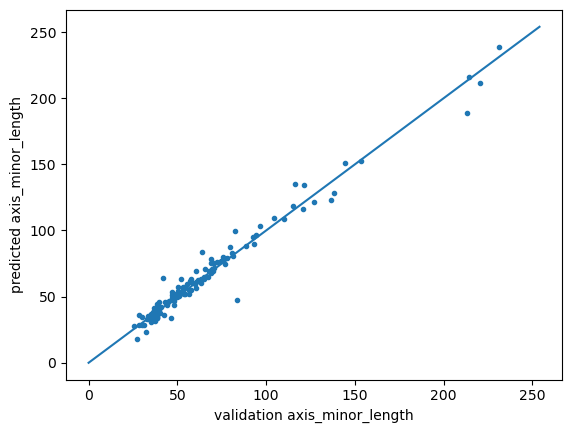

LinregressResult(slope=0.9810026018094632, intercept=1.9343352819374928, rvalue=0.9843366115715928, pvalue=8.075680839573525e-94, stderr=0.015907324366367014, intercept_stderr=1.202449979060526)


In [59]:
set_val = (measurements_outer_val['minor_axis_length'])
set_pred = (measurements_outer_pred['minor_axis_length'])

stats_val_pred = scipy.stats.linregress(set_val,set_pred)

x = np.arange(0,np.max(set_val)*1.1)
y = np.arange(0,np.max(set_val)*1.1)

plt.scatter(set_val,set_pred,marker='.')
plt.plot(x,y)
plt.xlabel('validation axis_minor_length')
plt.ylabel('predicted axis_minor_length')
plt.savefig(save_path + "\outer_minor.png",dpi=500)
plt.show()
print(stats_val_pred)

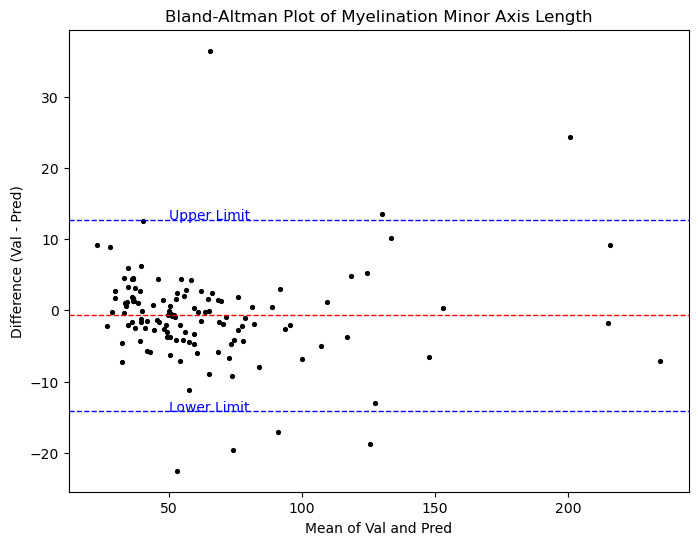

In [60]:
# Assuming set_val and set_pred are numpy arrays or lists
set_val = np.array(set_val)
set_pred = np.array(set_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30, marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of Myelination Minor Axis Length')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Save plot
plt.savefig(save_path + "\outer_minor_ba.png",dpi=500)

# Display the plot
plt.show()


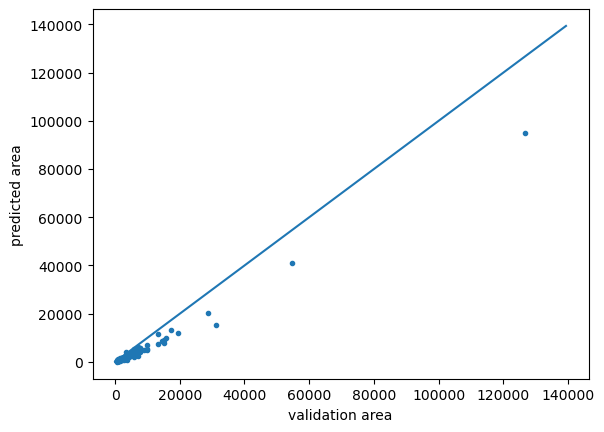

LinregressResult(slope=0.734197494290143, intercept=-379.5802918280333, rvalue=0.9941437236895383, pvalue=9.341972711379607e-120, stderr=0.007225581688391321, intercept_stderr=100.83101173106331)


In [61]:
set_val = (measurements_outer_val['area'])
set_pred = (measurements_outer_pred['area'])

stats_val_pred = scipy.stats.linregress(set_val,set_pred)

x = np.arange(0,np.max(set_val)*1.1)
y = np.arange(0,np.max(set_val)*1.1)

plt.scatter(set_val,set_pred,marker='.')
plt.plot(x,y)
plt.xlabel('validation area')
plt.ylabel('predicted area')
plt.savefig(save_path + "\outer_area.png",dpi=500)
plt.show()
print(stats_val_pred)

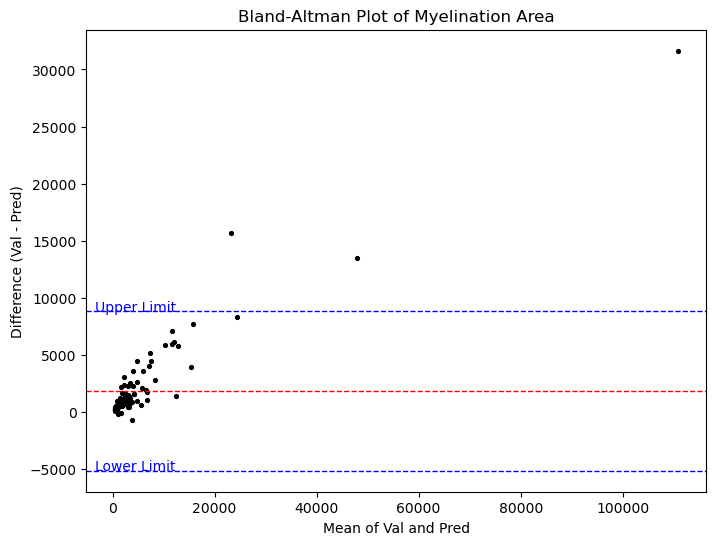

In [62]:
# Assuming set_val and set_pred are numpy arrays or lists
set_val = np.array(set_val)
set_pred = np.array(set_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30, marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of Myelination Area')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Save plot
plt.savefig(save_path + "\outer_area_ba.png",dpi=500)

# Display the plot
plt.show()


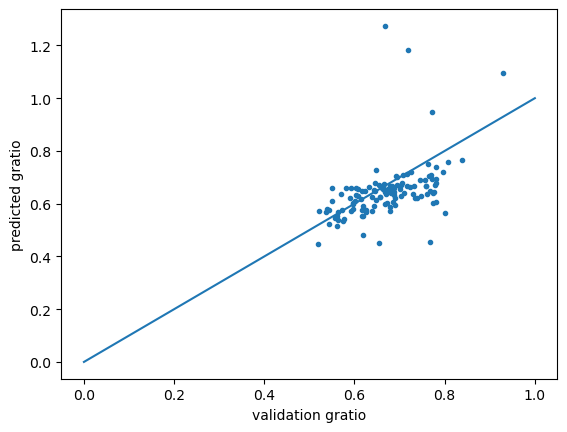

LinregressResult(slope=0.6539631388737555, intercept=0.2067356935310502, rvalue=0.46467313949370853, pvalue=5.429447957658418e-08, stderr=0.11282508300335682, intercept_stderr=0.07620361428628286)


In [63]:
gratio_pred = measurements_inner_pred['minor_axis_length']/measurements_outer_pred['minor_axis_length']
gratio_val  = measurements_inner_val['minor_axis_length']/measurements_outer_val['minor_axis_length']

stats_val_pred = scipy.stats.linregress(gratio_val,gratio_pred)

plt.scatter(gratio_val,gratio_pred,marker='.')
plt.plot([0, 1], [0, 1])
plt.xlabel('validation gratio')
plt.ylabel('predicted gratio')
plt.savefig(save_path + "\gratio.png",dpi=500)
plt.show()
print(stats_val_pred)

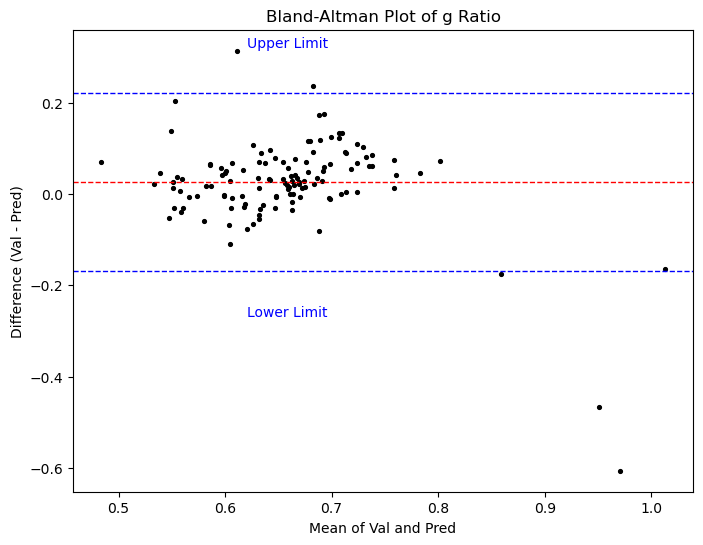

In [64]:
# Assuming set_val and set_pred are numpy arrays or lists
set_val = np.array(gratio_val)
set_pred = np.array(gratio_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30, marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of g Ratio')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Save plot
plt.savefig(save_path + "\gratio_ba.png",dpi=500)

# Display the plot
plt.show()

In [65]:
# print all statistics
print ("Correctly identified cells (prediction): " + str (len(set_pred)))
print ("False Positives (prediction): " + str (n_false_positive))
print ("False Negatives (prediction): " + str (n_false_negative))
print ("Percentage of cells found: " + str(len(set_pred)/(len(set_pred)+n_false_negative))) # found cells divided by found cells + false negatives
print ("Percentage of cells falsely identified: " + str(n_false_positive/(len(set_pred)+n_false_positive)))
print ("Cells removed because labeled without inner (prediction): " + str (n_labeled_without_inner))
print ("Cells removed because labeled without outer (prediction): " + str (n_labeled_without_outer))
print ("IoU for fibers, before removing false positives/negatives: " + str (iou_inner_before))
# print ("IoU for fibers, after removing false positives/negatives: " + str (iou_inner_after))
print ("IoU for myelin, before removing false positives/negatives: "+ str (iou_outer_before))
# print ("IoU for myelin, after removing false positives/negatives: " + str (iou_outer_after))
print ("dice coefficient / F1 score for fibers, before removing false positives/negatives: " + str (dice_inner_before))
# print ("dice coefficient / F1 score for fibers, after removing false positives/negatives: " + str (dice_inner_after))
print ("dice coefficient / F1 score for myelin, before removing false positives/negatives: " + str (dice_outer_before))
# print ("dice coefficient / F1 score for myelin, after removing false positives/negatives: " + str (dice_outer_after))

Correctly identified cells (prediction): 124
False Positives (prediction): 20
False Negatives (prediction): 29
Percentage of cells found: 0.8104575163398693
Percentage of cells falsely identified: 0.1388888888888889
Cells removed because labeled without inner (prediction): 0
Cells removed because labeled without outer (prediction): 21
IoU for fibers, before removing false positives/negatives: 0.7441988372924424
IoU for myelin, before removing false positives/negatives: 0.5549547630385203
dice coefficient / F1 score for fibers, before removing false positives/negatives: 0.8533417422152149
dice coefficient / F1 score for myelin, before removing false positives/negatives: 0.7137889490162264


In [66]:
#### code graveyard.

# n_false_positive = 0
# n_false_negative = 0

# # Here, we start to define which cell (in predicted data) belongs to which other cell (in validation data). 
# # Start by extracting centroids from the validation and prediction data.
# # centroids_val = regionprops_table(label_image=val_inner_labeled,properties=('centroid',))
# centroids_val = regionprops_table(label_image=val_both_labeled,properties=('centroid',))
# centroids_val_x = centroids_val['centroid-0']
# centroids_val_y = centroids_val['centroid-1']

# # centroids_pred = regionprops_table(label_image=pred_inner_labeled,properties=('centroid',))
# centroids_pred = regionprops_table(label_image=pred_both_labeled,properties=('centroid',))
# centroids_pred_x = centroids_pred['centroid-0']
# centroids_pred_y = centroids_pred['centroid-1']

# # stack arrays to 2-dimensional arrays
# val_points = np.column_stack((centroids_val_x, centroids_val_y))
# pred_points = np.column_stack((centroids_pred_x, centroids_pred_y))

# # initialize boolean array which has True values where centroids are for both sets of cells
# val_bool_array = np.zeros_like(pred_both_labeled, dtype=bool)
# for yx in val_points:
#     val_bool_array[round(yx[0]),round(yx[1])]=True

# pred_bool_array = np.zeros_like(pred_both_labeled, dtype=bool)
# for yx in pred_points:
#     pred_bool_array[round(yx[0]),round(yx[1])]=True

# # label centroid bool arrays by iterating through them
# bool_array_val_labeled,n = ndi.label(val_bool_array)
# bool_array_pred_labeled,n_pred = ndi.label(pred_bool_array)

# # iterate through validation cells, delete ones that do not have a matching predicted cell
# for id in np.unique(bool_array_val_labeled):
#     if id == 0:
#         continue
#     y,x = np.argwhere(bool_array_val_labeled==id)[0]
#     # if this statement is true, the cell has not been found. 
#     # therefore, we exclude it from further validation and flood fill it with 0's in validation data.
#     if pred_both_labeled[y,x] == 0:
#         val_both_labeled = skimage.segmentation.flood_fill(val_both_labeled,
#                                                           (y,x),
#                                                           new_value=0,
#                                                           )
#         print('deleted cell in validation data (found a false negative): ' + str(id))
#         n_false_negative += 1

# # iterate through predicted cells, delete ones that do not have a matching predicted cell
# for id in np.unique(bool_array_pred_labeled):
#     if id == 0:
#         continue
#     y,x = np.argwhere(bool_array_pred_labeled==id)[0]
    
#     if val_both_labeled[y,x]==0:# if there is no cell to test against, delete cell
#         pred_both_labeled = skimage.segmentation.flood_fill(image=pred_both_labeled,
#                                                        seed_point=(y,x),
#                                                        new_value=0,
#                                                        )
#         print('deleted cell in prediction data (found a false positive): ' + str(id))
#         n_false_positive +=1

# # Now, we need to label each specific cell with the same label in prediction and validation arrays.
# # To do that, we iterate through the prediction array and label the validation cells with the same number.
# # We do this by flood filling from each centroid.
# for id in np.unique(bool_array_val_labeled):
#     if id == 0:
#         continue
#     y,x = np.argwhere(bool_array_val_labeled==id)[0]

#     # if there is no cell at the point want to fill it in, delete cell altogether
#     if pred_both_labeled[y,x]==0: # if this is true: delete cell
#         val_both_labeled = skimage.segmentation.flood_fill(image=val_both_labeled,
#                                                            seed_point=(y,x),
#                                                            new_value=0,
#                                                           )
#         print("cell deleted: " + str(id) + str(" - found false negative"))
#         n_false_negative += 1
#         continue

#     # if there is a cell, fill it in with the same label as in mask_val_labeled
#     pred_both_labeled = skimage.segmentation.flood_fill(image=pred_both_labeled,
#                                                    seed_point=(y,x),
#                                                    new_value=id,
#                                                    )
    
#     # if there is a cell, fill it in with the same label as in mask_val_labeled
#     val_both_labeled = skimage.segmentation.flood_fill(image=val_both_labeled,
#                                                    seed_point=(y,x),
#                                                    new_value=id,
#                                                    )


# # bool_array_labeled_dil = ndi.binary_dilation(bool_array_val_labeled,iterations=10)

# plt.axis("off")
# plt.imshow(pred_both_labeled,cmap=glasbey,interpolation='None',vmin=0.1)
# # plt.imshow(np.ma.array(bool_array_labeled_dil, mask=bool_array_labeled_dil==0), interpolation='none', cmap=glasbey,vmin=0.1)
# plt.show()

# plt.axis("off")
# plt.imshow(val_both_labeled,cmap=glasbey,interpolation='None',vmin=0.1)
# # plt.imshow(np.ma.array(bool_array_labeled_dil, mask=bool_array_labeled_dil==0), interpolation='none', cmap=glasbey,vmin=0.1)
# plt.show()

# # plt.imshow(ndi.binary_dilation(bool_array_labeled,iterations=10))
# # plt.show()